In [2]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import yfinance as yf
import os
import glob
import zipfile
from pathlib import Path
from tqdm import tqdm
warnings.filterwarnings('ignore')
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from typing import List, Dict, Callable, Optional
from datetime import datetime, timedelta
from sklearn.decomposition import PCA
from pytrends import dailydata
from datetime import datetime
from scipy import stats

### Data Extraction and Formatting

In [ ]:
#zip_folder = Path(r"C:\Users\anany\OneDrive\Desktop\Cornell\3 - CFEM Fall 2025\Courses\ORIE 5253 - Asset Management Seminar\Project\Data")
#extract_root = Path(r"C:\Users\anany\OneDrive\Desktop\Cornell\3 - CFEM Fall 2025\Courses\ORIE 5253 - Asset Management Seminar\Project\Data\Extracted Data")

# Create "Extracted Data" folder if it doesn't exist
#extract_root.mkdir(exist_ok=True)

# Get list of all zip files in the Data folder
#zip_files = list(zip_folder.glob("*.zip"))
#print(f"Found {len(zip_files)} zip files to extract.")

#for zip_path in zip_files:
    # Destination subfolder named same as zip (without .zip)
#    dest_folder = extract_root / zip_path.stem
#    dest_folder.mkdir(exist_ok=True)

#    print(f"Extracting: {zip_path.name} -> {dest_folder}")

#    with zipfile.ZipFile(zip_path, 'r') as z:
#        z.extractall(dest_folder)

#print("\n Extraction complete!")
#print(f"All folders created inside: {extract_root}")

In [ ]:
# ---------------------------
# CONFIGURATION
# ---------------------------
BASE_DIR = r"C:\Users\anany\OneDrive\Desktop\Cornell\3 - CFEM Fall 2025\Courses\ORIE 5253 - Asset Management Seminar\Project\Data\Extracted Data"
OUTPUT_FILE = "insider_trades_with_ticker_NEW.csv"

# ---------------------------
# Function to Process a Quarter
# ---------------------------
def process_quarter(quarter_folder):
    # print(f"Processing: {quarter_folder}")

    submission_file = os.path.join(quarter_folder, "SUBMISSION.tsv")
    owner_file = os.path.join(quarter_folder, "REPORTINGOWNER.tsv")
    nond_file = os.path.join(quarter_folder, "NONDERIV_TRANS.tsv")
    footnote_file = os.path.join(quarter_folder, "FOOTNOTES.tsv")

    try:
        df_sub = pd.read_csv(submission_file, sep="\t", dtype=str, low_memory=False)
        df_own = pd.read_csv(owner_file, sep="\t", dtype=str, low_memory=False)
        df_nond = pd.read_csv(nond_file, sep="\t", dtype=str, low_memory=False)
        df_footnote = pd.read_csv(footnote_file, sep="\t", dtype=str, low_memory=False)
    except FileNotFoundError:
        print(f"⚠ Missing required files in {quarter_folder}. Skipping...")
        return None

    # Keep ticker symbol and core submission info
    df_sub = df_sub[['ACCESSION_NUMBER', 'FILING_DATE', 'PERIOD_OF_REPORT', 'ISSUERTRADINGSYMBOL']]

    # Keep owner names and IDs
    df_own = df_own[['ACCESSION_NUMBER', 'RPTOWNERNAME', 'RPTOWNERCIK', 'RPTOWNER_RELATIONSHIP', 'RPTOWNER_TITLE']]

    # Keep transaction table fields
    df_nond = df_nond[['ACCESSION_NUMBER', 'SECURITY_TITLE', 'TRANS_DATE', 'TRANS_CODE',
                       'TRANS_SHARES', 'TRANS_PRICEPERSHARE', 'SHRS_OWND_FOLWNG_TRANS']]

    df_footnote = df_footnote[['ACCESSION_NUMBER', 'FOOTNOTE_ID', 'FOOTNOTE_TXT']]

    # Merge: transaction + submission + owner
    df_merge = df_nond.merge(df_sub, on="ACCESSION_NUMBER", how="left") \
                      .merge(df_own, on="ACCESSION_NUMBER", how="left") \
                      .merge(df_footnote, on="ACCESSION_NUMBER", how="left")

    # Convert numeric fields
    df_merge['TRANS_SHARES'] = pd.to_numeric(df_merge['TRANS_SHARES'], errors='coerce')
    df_merge['TRANS_PRICEPERSHARE'] = pd.to_numeric(df_merge['TRANS_PRICEPERSHARE'], errors='coerce')
    df_merge['SHRS_OWND_FOLWNG_TRANS'] = pd.to_numeric(df_merge['SHRS_OWND_FOLWNG_TRANS'], errors='coerce')

    # Calculate transaction amount
    df_merge['TRANSACTION_AMOUNT'] = df_merge['TRANS_SHARES'] * df_merge['TRANS_PRICEPERSHARE']

    return df_merge

# ---------------------------
# Main Function — processes all quarters and concatenates
# ---------------------------
def process_all_quarters(base_directory):
    consolidated = []
    all_folders = glob.glob(os.path.join(base_directory, "*"))

    for folder in all_folders:
        if os.path.isdir(folder):
            df = process_quarter(folder)
            if df is not None:
                consolidated.append(df)

    final_df = pd.concat(consolidated, ignore_index=True)
    print(f"Total transactions: {len(final_df):,}")

    if 'FOOTNOTE_TXT' in final_df.columns:
        final_df['IS_10B51'] = final_df['FOOTNOTE_TXT'].astype(str).str.contains(
            '10b5-1', case=False, na=False
        ).astype(int)
        
        print(f"10b5-1 plan transactions: {final_df['IS_10B51'].sum():,}")
        print(f"Non-10b5-1 transactions: {(final_df['IS_10B51'] == 0).sum():,}")
        print(f"Percentage of 10b5-1 plans: {final_df['IS_10B51'].mean():.2%}")
    else:
        print("FOOTNOTE column not found - setting IS_10B51 to 0 for all rows")
        final_df['IS_10B51'] = 0
    
    final_df.to_csv(OUTPUT_FILE, index=False)
    print(f" Final dataset saved to {OUTPUT_FILE}")
    return final_df

final_data = process_all_quarters(BASE_DIR)

In [ ]:
# extracted all insider data from 2006
final_data = pd.read_csv("insider_trades_with_ticker_NEW.csv")
# focusing on stocks active since 2015 so we can come up with a working strategy
tickers_list = pd.read_csv("CRSP_SP500_Constituents_since_2015.csv")
tickers = tickers_list['HTSYMBOL'].unique()

# filter out rows that only include the above tickers
final_data = final_data[final_data['ISSUERTRADINGSYMBOL'].isin(tickers)]

In [ ]:
final_data.sort_values(by='TRANS_DATE', inplace=True)

# segregating buy and sell transactions
buy_codes = ['P', 'M', 'C', 'A', 'G']
sell_codes = ['S', 'D']

final_data = final_data[
    final_data['TRANS_CODE'].isin(buy_codes + sell_codes)]

# Calculate the difference in days
final_data['FILING_DATE'] = pd.to_datetime(final_data['FILING_DATE'], errors='coerce')
final_data['TRANS_DATE'] = pd.to_datetime(final_data['TRANS_DATE'], errors='coerce')
final_data['Days_Diff'] = (final_data['FILING_DATE'] - final_data['TRANS_DATE']).dt.days

In [ ]:
# Keep only transactions that were reported within 7 days of occurring
print(final_data)
final_data = final_data[(final_data['Days_Diff'] <= 7) & (final_data['Days_Diff'] >= 0)]

print(f"Final dataset size after filtering: {len(final_data):,} rows")

# dataset with encoded buy/sell, all transactions, filtered for tickers, and dropped anomolous date rows
final_data.to_csv("Insider_Trading_Data_SP500_NEW.CSV",index = False)

In [ ]:
final_data = pd.read_csv("Insider_Trading_Data_SP500_NEW.CSV")

In [ ]:
# downloading stock price data
final_data['TRANS_DATE'] = pd.to_datetime(final_data['TRANS_DATE'])
final_data['FILING_DATE'] = pd.to_datetime(final_data['FILING_DATE'])
price_cache = {}
for ticker in final_data['ISSUERTRADINGSYMBOL'].unique():
    df = yf.download(ticker, start="2000-01-01", end="2025-12-12", progress=False)
    if not df.empty:
        df = df[['Close']].reset_index()
        price_cache[ticker] = df

In [ ]:
def clean_prices(df):
    """Convert yfinance output into a clean df with ['Date','Close']"""
    if df is None or len(df) == 0:
        return None

    # If Series → convert to DataFrame
    if isinstance(df, pd.Series):
        df = df.to_frame('Close')

    # If MultiIndex columns → flatten
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in df.columns]

    # If no 'Close' column → find one containing 'Close'
    close_col = None
    for col in df.columns:
        if 'Close' in col:
            close_col = col
            break
    if close_col is None:
        return None  # No price data available

    # Ensure 'Date' exists (from index)
    if 'Date_' not in df.columns:
        df = df.reset_index()  # This will create 'Date' or 'index' column depending on index name

    # Check again
    if 'Date_' not in df.columns:
        # Index wasn't named 'Date', rename accordingly
        df = df.rename(columns={df.columns[0]: 'Date_'})

    # Keep only needed columns
    df = df[['Date_', close_col]].rename(columns={close_col: 'Close'})

    df = df.dropna().sort_values('Date_')
    return df
    
def add_prices(group):
    ticker = group.name
    prices = price_cache.get(ticker)
    prices = clean_prices(prices)

    if prices is None or prices.empty:
        return group

    # Ensure Date in prices is datetime
    prices['Date_'] = pd.to_datetime(prices['Date_'])

    group = group.copy()

    # Ensure base dates are datetime
    group['TRANS_DATE'] = pd.to_datetime(group['TRANS_DATE'])
    group['FILING_DATE'] = pd.to_datetime(group['FILING_DATE'])

    # Create shifted dates: 1 week, 1 month, 2 months, 3 months, 4 months, 6 months, 1 year
    # calendar day approximations
    group['t_0']  = group['TRANS_DATE']
    group['t_5']  = group['TRANS_DATE'] + pd.Timedelta(days=7)
    group['t_21'] = group['TRANS_DATE'] + pd.Timedelta(days=30)
    group['t_45'] = group['TRANS_DATE'] + pd.Timedelta(days=60)
    group['t_60'] = group['TRANS_DATE'] + pd.Timedelta(days=90)
    group['t_90'] = group['TRANS_DATE'] + pd.Timedelta(days=120)
    group['t_120'] = group['TRANS_DATE'] + pd.Timedelta(days=150)
    group['t_252'] = group['TRANS_DATE'] + pd.Timedelta(days=360)

    group['r_0']  = group['FILING_DATE']
    group['r_5']  = group['FILING_DATE'] + pd.Timedelta(days=7)
    group['r_21'] = group['FILING_DATE'] + pd.Timedelta(days=30)
    group['r_45'] = group['FILING_DATE'] + pd.Timedelta(days=60)
    group['r_60'] = group['FILING_DATE'] + pd.Timedelta(days=90)
    group['r_90'] = group['FILING_DATE'] + pd.Timedelta(days=120)
    group['r_120'] = group['FILING_DATE'] + pd.Timedelta(days=150)
    group['r_252'] = group['FILING_DATE'] + pd.Timedelta(days=360)

    # Force all as datetime (prevents int64 errors)
    for col in ['t_0', 't_5', 't_21', 't_45', 't_60', 't_90', 't_120', 't_252', 'r_0', 'r_5', 'r_21', 'r_45', 'r_60', 'r_90', 'r_120', 'r_252']:
        group[col] = pd.to_datetime(group[col], errors='coerce')

    # Merge prices for each target date
    for price_col, date_col in {
        'price_trans': 't_0',
        'price_t_5': 't_5',
        'price_t_21': 't_21',
        'price_t_45': 't_45',
        'price_t_60': 't_60',
        'price_t_90': 't_90',
        'price_t_120': 't_120',
        'price_t_252': 't_252',
        'price_report': 'r_0',
        'price_r_5': 'r_5',
        'price_r_21': 'r_21',
        'price_r_45': 'r_45',
        'price_r_60': 'r_60',
        'price_r_90': 'r_90',
        'price_r_120': 'r_120',
        'price_r_252': 'r_252'
    }.items():
        # Skip if merge column has no valid dates
        if group[date_col].isna().all():
            group[price_col] = None
            continue

        group = pd.merge_asof(
            group.sort_values(date_col),
            prices.rename(columns={'Date_': 'date', 'Close': price_col}),
            left_on=date_col,
            right_on='date',
            direction='forward'
        ).drop(columns=['date'])
    return group

final_data = (
    final_data
    .sort_values('TRANS_DATE')
    .groupby('ISSUERTRADINGSYMBOL', group_keys=False)
    .apply(add_prices)
    .reset_index(drop=True)
)

In [ ]:
final_data.dropna(inplace=True)
final_data.reset_index(inplace=True, drop=True)
final_data.head()

In [ ]:
# Calculate forward returns at multiple horizons
for horizon in [5, 21, 45, 60, 90, 120, 252]:
    final_data[f"return_t_to_t{horizon}"] = (
        (final_data[f"price_t_{horizon}"] - final_data["price_trans"])
        / final_data["price_trans"]
    )

for horizon in [5, 21, 45, 60, 90, 120, 252]:
    final_data[f"return_r_to_r{horizon}"] = (
        (final_data[f"price_r_{horizon}"] - final_data["price_report"])
        / final_data["price_report"]
    )

# encoding the signal for buy/sell - binary
final_data['Signal'] = final_data['TRANS_CODE'].apply(
    lambda x: 1 if x in buy_codes else -1
)

print(final_data['Signal'].value_counts())

In [ ]:
final_data.to_csv("Insider_Trading_Data_SP500_with_Prices_NEW.csv",index = False)

In [ ]:
# adding industry and sector to the dataframe
unique_tickers = (
    final_data["ISSUERTRADINGSYMBOL"]
    .dropna()
    .unique()
)

industry_sector_map = {}

print(f" Fetching sector/industry data for {len(unique_tickers)} unique tickers...")

for ticker in unique_tickers:
    try:
        t = yf.Ticker(ticker)
        info = t.info

        industry_sector_map[ticker] = {
            "Industry": info.get("industry"),
            "Sector": info.get("sector"),
        }

    except Exception as e:
        # If ticker fails → record empty
        industry_sector_map[ticker] = {
            "Industry": None,
            "Sector": None,
        }

# Map back to your dataframe
final_data["Industry"] = final_data["ISSUERTRADINGSYMBOL"].map(
    lambda x: industry_sector_map.get(x, {}).get("Industry")
)
final_data["Sector"] = final_data["ISSUERTRADINGSYMBOL"].map(
    lambda x: industry_sector_map.get(x, {}).get("Sector")
)

final_data.to_csv('Insider_Trading_Data_SP500_with_Prices_NEW_2.csv', index=False)
print(" Sector & Industry columns added and CSV updated.")

In [ ]:
# checking coverage --------------------------
missing_industry = final_data["Industry"].isna().sum()
missing_sector   = final_data["Sector"].isna().sum()

total_rows = len(final_data)

print("------ Industry / Sector Availability ------")
print(f"Total rows                        : {total_rows:,}")
print(f"Rows with missing Industry        : {missing_industry:,}")
print(f"Rows with missing Sector          : {missing_sector:,}")
print(f"Rows with Industry available      : {total_rows - missing_industry:,}")
print(f"Rows with Sector available        : {total_rows - missing_sector:,}")

# --------------------------
# Count null / non-null for owner relationship/title
# --------------------------

rel_null     = final_data["RPTOWNER_RELATIONSHIP"].isna().sum()
rel_not_null = final_data["RPTOWNER_RELATIONSHIP"].notna().sum()

title_null     = final_data["RPTOWNER_TITLE"].isna().sum()
title_not_null = final_data["RPTOWNER_TITLE"].notna().sum()

print("\n------ Reporting Owner Metadata ------")
print(f"RPTOWNER_RELATIONSHIP — NOT NULL : {rel_not_null:,}")
print(f"RPTOWNER_RELATIONSHIP — NULL     : {rel_null:,}")
print(f"RPTOWNER_TITLE — NOT NULL        : {title_not_null:,}")
print(f"RPTOWNER_TITLE — NULL            : {title_null:,}")

In [ ]:
print("Final transaction code distribution:")
print(final_data['TRANS_CODE'].value_counts())

### Data Cleaning

In [ ]:
# already accounted for anomalous rows where days_diff < 0 -> error in filing

# added additional flags for further analysis during regression
  # transactions 'A' or 'G': grant or award (equity compensation), and gift. 
  # only focus on pure buy signals (P=open mkt purchases (insider spending own cash), C=conversion of derivative (can indicate bullishness)
  # only focus on pure sell signals (S=open market sales, sales back to issuer)
  # extra column to know if its a 10b51 transaction or not

In [ ]:
print(f"Initial data size: {len(final_data):,}")
print(f"Missing transaction dates: {final_data['TRANS_DATE'].isna().sum()}")
print(f"Missing filing dates: {final_data['FILING_DATE'].isna().sum()}")

# Filter out problematic rows before processing
final_data = final_data[
    final_data['TRANS_DATE'].notna() & 
    final_data['FILING_DATE'].notna() &
    final_data['TRANS_SHARES'].notna() &
    (final_data['TRANS_SHARES'] > 0)  # Remove zero/negative transactions
]

In [ ]:
len(final_data)

In [ ]:
def validate_data(final_data):
    # Check for duplicate transactions
    duplicates = final_data.duplicated(subset=['ACCESSION_NUMBER', 'RPTOWNERCIK', 'TRANS_DATE', 'TRANS_SHARES']).sum()
    print(f"Duplicate transactions: {duplicates}")
    
    # Check for unrealistic transaction sizes
    large_transactions = final_data[final_data['TRANSACTION_AMOUNT'] > 1e9]  # $1B+
    print(f"Extremely large transactions: {len(large_transactions)}")
    
    # Verify date logic
    future_dates = final_data[final_data['TRANS_DATE'] > final_data['FILING_DATE'] + pd.Timedelta(days=7)]
    print(f"Transactions filed too early: {len(future_dates)}")

validate_data(final_data)

In [ ]:
# transaction insignifance 
final_data['TRANS_SIZE_RATIO'] = final_data['TRANS_SHARES'] / final_data['SHRS_OWND_FOLWNG_TRANS']
significant_trades = final_data[final_data['TRANS_SIZE_RATIO'] > 0.01]  # 1% threshold
print(len(final_data), len(significant_trades))

In [ ]:
# Filter for meaningful transaction sizes
def filter_significant_trades(df):
    # Method 1: Absolute dollar amount
    significant_amount = df['TRANSACTION_AMOUNT'] > 10000  # $10k minimum
    
    # Method 2: Percentage of shares owned
    df['OWNERSHIP_PCT'] = df['TRANS_SHARES'] / df['SHRS_OWND_FOLWNG_TRANS']
    significant_pct = df['OWNERSHIP_PCT'] > 0.01  # 1% of position
    
    # Method 3: Combine both criteria
    significant_trades = significant_amount & significant_pct
    
    return df[significant_trades]

final_significant_data = filter_significant_trades(final_data)
print(f"After filtering for significant trades: {len(final_significant_data):,} rows")

In [ ]:
final_data.RPTOWNER_RELATIONSHIP.unique()

In [ ]:
# cluster analysis - aggregating multiple filings by the same insider within short-time periods?

### Adding SP500 Data

In [ ]:
insider_df = pd.read_csv("Insider_Trading_Data_SP500_with_Prices_NEW_2.csv")
insider_df.columns

In [ ]:
insider_df["TRANS_DATE"] = pd.to_datetime(insider_df["TRANS_DATE"])
insider_df["FILING_DATE"] = pd.to_datetime(insider_df["FILING_DATE"])

In [ ]:
sp500 = yf.download("^GSPC", start=insider_df["TRANS_DATE"].min() - pd.Timedelta(days=400),
                    end=insider_df["TRANS_DATE"].max() + pd.Timedelta(days=400))
if isinstance(sp500.columns, pd.MultiIndex):
    sp500 = sp500['Close']['^GSPC']
else:
    sp500 = sp500['Close']
sp500 = sp500.rename("SP500")

def get_sp500_price(date, days):
    target_date = date + pd.Timedelta(days=days)
    try:
        #return sp500.loc[:target_date].iloc[-1]
        future_prices = sp500[sp500.index >= target_date]
        if not future_prices.empty:
            return future_prices.iloc[0]
        else:
            return None
    except:
        return None
    
sp500_horizons = {
    "t_0": 0,
    "t_5": 7,
    "t_21": 30,
    "t_45": 60,
    "t_60": 90,
    "t_90": 120,
    "t_120": 150,
    "t_252": 360,
    "r_0": 0,
    "r_5": 7,
    "r_21": 30,
    "r_45": 60,
    "r_60": 90,
    "r_90": 120,
    "r_120": 150,
    "r_252": 360,
}
    
# Compute SP500 prices for each horizon
for col, offset in sp500_horizons.items():
    if col.startswith("t_"):
        insider_df[f"sp500_{col}"] = insider_df["TRANS_DATE"].apply(lambda d: get_sp500_price(d, offset))
    else:
        insider_df[f"sp500_{col}"] = insider_df["FILING_DATE"].apply(lambda d: get_sp500_price(d, offset))

# === Compute S&P500 returns for each horizon (relative returns) ===
for h in ["5", "21", "45", "60", "90", "120", "252"]:
    insider_df[f"sp500_return_t_to_t{h}"] = (
        insider_df[f"sp500_t_{h}"] - insider_df["sp500_t_0"]
    ) / insider_df["sp500_t_0"]

    insider_df[f"sp500_return_r_to_r{h}"] = (
        insider_df[f"sp500_r_{h}"] - insider_df["sp500_r_0"]
    ) / insider_df["sp500_r_0"]

# === Compute relative returns (stock minus market) ===
for h in ["5", "21", "45", "60", "90", "120", "252"]:
    insider_df[f"relative_return_t_to_t{h}"] = (
        insider_df[f"return_t_to_t{h}"] - insider_df[f"sp500_return_t_to_t{h}"]
    )
    insider_df[f"relative_return_r_to_r{h}"] = (
        insider_df[f"return_r_to_r{h}"] - insider_df[f"sp500_return_r_to_r{h}"]
    )

insider_df.to_csv('Insider Final NEW.csv')

### Running Regressions & Hypothesis Testing

In [123]:
insider_df = pd.read_csv("Insider Final NEW.csv")

In [124]:
tickers = insider_df['ISSUERTRADINGSYMBOL'].unique().tolist()

insider_df['TRANS_SHARES_SIGN'] = insider_df['TRANS_SHARES']*insider_df['Signal'] #buy - positive, sell - negative; with number of shares
insider_df['TRANSACTION_AMOUNT_SIGN'] = insider_df['TRANSACTION_AMOUNT']*insider_df['Signal']

In [169]:
# for running the second regression
# dropping 10b51 rows
# dropping A, G, C transaction codes

print(len(insider_df))
insider_df_ = insider_df[insider_df['IS_10B51'] == 0]
insider_df_ = insider_df_[~insider_df_.TRANS_CODE.isin(['A', 'G', 'C'])]
print(len(insider_df_))

3066566
2419033


In [376]:
# identify all columns that start with these prefixes
return_cols = [c for c in insider_df.columns if c.startswith("return_")]
relative_cols = [c for c in insider_df.columns if c.startswith("relative_return_")]

grouped_df = (
    insider_df
    .groupby(['FILING_DATE', 'ISSUERTRADINGSYMBOL'])
    .agg(
        {
            'TRANS_SHARES_SIGN': 'sum',
            'price_report': 'mean',
            'Days_Diff': 'mean',
            **{col: 'mean' for col in return_cols},
            **{col: 'mean' for col in relative_cols},
        }
    )
    .reset_index()
)


In [377]:
grouped_df = grouped_df[grouped_df['TRANS_SHARES_SIGN'] != 0] #only buys and sells

In [378]:
grouped_df['NET_TRANSACTION'] = grouped_df['TRANS_SHARES_SIGN']*grouped_df['price_report']

In [379]:
grouped_df_n = grouped_df[(grouped_df['NET_TRANSACTION'] >1_000_000) | (grouped_df['NET_TRANSACTION'] < - 1_000_000)]

In [350]:
grouped_df_n.sort_values(by = 'FILING_DATE',inplace=True)
grouped_df_n.reset_index(inplace=True,drop=True)

In [380]:
ff_factors_df = pd.read_csv("F-F_Research_Data_Factors_daily.csv",skiprows=4)
ff_factors_df.columns = ['Date','Mkt-RF','SMB','HML','RF']
ff_factors_df['Date'] = pd.to_datetime(ff_factors_df['Date'].astype(str), format='%Y%m%d',errors='coerce')
ff_factors_df

,Date,Mkt-RF,SMB,HML,RF
0,1926-07-08,0.22,-0.38,0.19,0.01
1,1926-07-09,-0.71,0.43,0.57,0.01
2,1926-07-10,0.61,-0.53,-0.10,0.01
3,1926-07-12,0.04,-0.03,0.64,0.01
4,1926-07-13,0.48,-0.28,-0.20,0.01
...,...,...,...,...,...
26058,2025-08-26,0.43,0.25,0.13,0.02
26059,2025-08-27,0.24,0.40,0.27,0.02
26060,2025-08-28,0.35,-0.15,-0.52,0.02
26061,2025-08-29,-0.68,0.02,0.85,0.02


In [381]:
ff = ff_factors_df.copy()
window = 30
# .shift(-window)
#ff['cum_MKT_RF'] = ff['Mkt-RF'].rolling(window).sum().shift(-window)
#ff['cum_SMB']    = ff['SMB'].rolling(window).sum().shift(-window)
#ff['cum_HML']    = ff['HML'].rolling(window).sum().shift(-window)
#ff['cum_RF']     = ff['RF'].rolling(window).sum().shift(-window)

# FIXED - Fama-French factors are already daily excess returns
# For a 7-day window, you should compound, not sum
def compound_returns(returns, window):
    return (1 + returns).rolling(window).apply(lambda x: x.prod() - 1, raw=True).shift(-window)

ff['cum_MKT_RF'] = compound_returns(ff['Mkt-RF']/100, window)  # Divide by 100 since FF factors are in percent
ff['cum_SMB'] = compound_returns(ff['SMB']/100, window)
ff['cum_HML'] = compound_returns(ff['HML']/100, window)
ff['cum_RF'] = compound_returns(ff['RF']/100, window)

In [353]:
# Suppose df_events has TRANS_DATE
grouped_df_n["FILING_DATE"] = pd.to_datetime(grouped_df_n["FILING_DATE"])
df_events = grouped_df_n.merge(ff,
                            left_on='FILING_DATE', right_on = 'Date', how='left')
df_events

,FILING_DATE,ISSUERTRADINGSYMBOL,TRANS_SHARES_SIGN,price_report,Days_Diff,return_t_to_t5,return_t_to_t21,return_t_to_t45,return_t_to_t60,return_t_to_t90,return_t_to_t120,return_t_to_t252,return_r_to_r5,return_r_to_r21,return_r_to_r45,return_r_to_r60,return_r_to_r90,return_r_to_r120,return_r_to_r252,relative_return_t_to_t5,relative_return_r_to_r5,relative_return_t_to_t21,relative_return_r_to_r21,relative_return_t_to_t45,relative_return_r_to_r45,relative_return_t_to_t60,relative_return_r_to_r60,relative_return_t_to_t90,relative_return_r_to_r90,relative_return_t_to_t120,relative_return_r_to_r120,relative_return_t_to_t252,relative_return_r_to_r252,NET_TRANSACTION,Date,Mkt-RF,SMB,HML,RF,cum_MKT_RF,cum_SMB,cum_HML,cum_RF
0,2006-01-03,JEF,104874.00,14.988743,5.000000,0.006514,0.085522,0.133431,0.233032,0.276529,0.344611,0.212924,0.019769,0.114196,0.142166,0.261830,0.286646,0.335227,0.196966,-0.008680,0.003304,0.060993,0.112588,0.101783,0.134710,0.194393,0.238966,0.231735,0.255656,0.340266,0.319921,0.083398,0.079138,1.571929e+06,2006-01-03,1.50,-0.17,0.16,0.02,0.011001,0.047100,0.002431,0.006017
1,2006-01-03,O,283500.00,7.783294,2.000000,0.033785,0.054309,0.057766,0.077983,0.021107,0.008935,0.331711,0.037388,0.046613,0.055036,0.077983,0.024783,0.037578,0.324823,0.016958,0.020923,0.045418,0.045006,0.041735,0.047580,0.055119,0.055119,-0.007573,-0.006207,0.007919,0.022272,0.207153,0.206995,2.206564e+06,2006-01-03,1.50,-0.17,0.16,0.02,0.011001,0.047100,0.002431,0.006017
2,2006-01-04,VLO,593488.00,28.363340,3.666667,0.070204,0.173295,0.032093,0.142283,0.254645,0.170381,-0.012650,0.037151,0.067747,-0.001185,0.091076,0.184612,0.107262,-0.083717,0.044870,0.020881,0.153052,0.075152,0.012320,-0.004954,0.106912,0.065578,0.213927,0.154151,0.159095,0.113678,-0.141974,-0.196119,1.683330e+07,2006-01-04,0.46,0.36,0.02,0.02,0.013919,0.043970,0.004336,0.006017
3,2006-01-04,QCOM,41000.00,28.889509,1.357143,0.074071,0.069031,0.078335,0.165540,0.178611,0.070123,-0.131284,0.074180,0.014308,0.041839,0.142627,0.154315,0.010106,-0.166334,0.057697,0.057909,0.065786,0.021713,0.069151,0.038070,0.141549,0.117129,0.146635,0.123855,0.055601,0.016521,-0.249947,-0.278736,1.184470e+06,2006-01-04,0.46,0.36,0.02,0.02,0.013919,0.043970,0.004336,0.006017
4,2006-01-04,MMC,381987.56,20.399961,2.481481,0.026486,-0.046045,-0.013902,-0.071589,-0.035230,-0.107642,-0.009484,0.031516,-0.045698,-0.025843,-0.070281,-0.041118,-0.105466,0.003364,0.009659,0.015245,-0.055908,-0.038293,-0.029153,-0.029613,-0.094453,-0.095778,-0.067188,-0.071578,-0.115042,-0.099050,-0.133181,-0.109038,7.792532e+06,2006-01-04,0.46,0.36,0.02,0.02,0.013919,0.043970,0.004336,0.006017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43772,2024-11-15,APTV,378696.00,52.930000,1.000000,-0.012400,0.073478,0.121784,0.211364,0.170276,-0.072737,0.528040,0.027395,0.095787,0.161345,0.254676,0.183639,-0.053467,0.559796,-0.012323,0.010579,0.052481,0.061130,0.140770,0.166065,0.194084,0.213037,0.222423,0.216940,0.018569,0.025681,0.379572,0.395961,2.004438e+07,2024-11-15,-1.38,-0.87,1.65,0.02,-0.001035,0.001322,-0.047598,0.006017
43773,2024-11-15,AKAM,-17000.00,87.430000,0.000000,0.062564,0.112890,0.036029,0.139883,-0.053071,-0.151893,-0.003546,0.062564,0.112890,0.036029,0.139883,-0.053071,-0.151893,-0.003546,0.045748,0.045748,0.078233,0.078233,0.040749,0.040749,0.098244,0.098244,-0.019770,-0.019770,-0.072745,-0.072745,-0.167380,-0.167380,-1.486310e+06,2024-11-15,-1.38,-0.87,1.65,0.02,-0.001035,0.001322,-0.047598,0.006017
43774,2024-11-15,STZ,-280760.00,231.630280,1.100000,-0.005010,-0.034205,-0.231365,-0.328649,-0.245737,-0.221141,-0.455365,0.009052,-0.019326,-0.232874,-0.308788,-0.222344,-0.206842,-0.445366,-0.003800,-0.007764,-0.054199,-0.053983,-0.211786,-0.228154,-0.345589,-0.350427,-0.191055,-0.189042,-0.129285,-0.127694,-0.603138,-0.609201,-6.503252e+07,2024-11-15,-1.38,-0.87,1.65,0.02,-0.00

In [306]:
df_events['excess_r5'] = df_events['return_r_to_r5'] - df_events['cum_RF']
df_events['insider_signal'] = np.sign(df_events['TRANS_SHARES_SIGN'])

In [307]:
print(f"Events with missing factor data: {df_events['cum_MKT_RF'].isnull().sum()}")
print(f"Total events for analysis: {len(df_events)}")

Events with missing factor data: 59
Total events for analysis: 31667


In [308]:
# Add these checks before regression
print("\n=== DATA QUALITY CHECKS ===")
print(f"Missing FF factors: {df_events[['cum_MKT_RF','cum_SMB','cum_HML','cum_RF']].isnull().sum()}")
print(f"Return statistics:")
print(f"  excess_r5 mean: {df_events['excess_r5'].mean():.4f}")
print(f"  excess_r5 std: {df_events['excess_r5'].std():.4f}")

# Check for extreme outliers
q_low = df_events['excess_r5'].quantile(0.01)
q_high = df_events['excess_r5'].quantile(0.99)
print(f"Extreme returns (<1% or >99%): {((df_events['excess_r5'] < q_low) | (df_events['excess_r5'] > q_high)).sum()}")


=== DATA QUALITY CHECKS ===
Missing FF factors: cum_MKT_RF    59
cum_SMB       59
cum_HML       59
cum_RF        59
dtype: int64
Return statistics:
  excess_r5 mean: 0.0016
  excess_r5 std: 0.0444
Extreme returns (<1% or >99%): 634


In [309]:
# Test different specifications
def run_multiple_specifications(df_events):
    stock_counts = df_events.groupby('ISSUERTRADINGSYMBOL').size()
    qualified_stocks = stock_counts[stock_counts >= 5].index  # Lower threshold for FE
    df_filtered = df_events[df_events['ISSUERTRADINGSYMBOL'].isin(qualified_stocks)]
    df_filtered['year'] = df_filtered['FILING_DATE'].dt.year
    specifications = {
        'Basic': 'excess_r5 ~ insider_signal',
        'With_FF3': 'excess_r5 ~ cum_MKT_RF + cum_SMB + cum_HML + insider_signal',
        'With_FE': 'excess_r5 ~ cum_MKT_RF + cum_SMB + cum_HML + insider_signal + C(ISSUERTRADINGSYMBOL)',
        'With_FE_Time': 'excess_r5 ~ cum_MKT_RF + cum_SMB + cum_HML + insider_signal + C(ISSUERTRADINGSYMBOL) + C(year)'
    }
    
    results = {}
    for name, formula in specifications.items():
        try:
            model = smf.ols(formula, data=df_filtered).fit(cov_type='HC1')
            results[name] = model
            print(f"\n{name}:")
            print(f"  Insider coef: {model.params.get('insider_signal', 'N/A'):.6f}")
            print(f"  P-value: {model.pvalues.get('insider_signal', 'N/A'):.4f}")
        except Exception as e:
            print(f"Error in {name}: {e}")
    
    return results

run_multiple_specifications(df_events)


Basic:
  Insider coef: 0.000069
  P-value: 0.7868

With_FF3:
  Insider coef: 0.000279
  P-value: 0.2202

With_FE:
  Insider coef: 0.000825
  P-value: 0.0023

With_FE_Time:
  Insider coef: 0.000895
  P-value: 0.0011


{'Basic': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x17993506330>,
 'With_FF3': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x17993595760>,
 'With_FE': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x17a6b4a6e40>,
 'With_FE_Time': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x17a9e2503b0>}

### Improving Signal/Noise Ratio

In [354]:
insider_df = pd.read_csv("Insider Final NEW.csv")

In [355]:
tickers = insider_df['ISSUERTRADINGSYMBOL'].unique().tolist()

insider_df['TRANS_SHARES_SIGN'] = insider_df['TRANS_SHARES']*insider_df['Signal'] #buy - positive, sell - negative; with number of shares
insider_df['TRANSACTION_AMOUNT_SIGN'] = insider_df['TRANSACTION_AMOUNT']*insider_df['Signal']

In [356]:
pd.set_option('display.max_columns', 1000)
print(insider_df.columns.tolist())

['Unnamed: 0', 'ACCESSION_NUMBER', 'SECURITY_TITLE', 'TRANS_DATE', 'TRANS_CODE', 'TRANS_SHARES', 'TRANS_PRICEPERSHARE', 'SHRS_OWND_FOLWNG_TRANS', 'FILING_DATE', 'PERIOD_OF_REPORT', 'ISSUERTRADINGSYMBOL', 'RPTOWNERNAME', 'RPTOWNERCIK', 'RPTOWNER_RELATIONSHIP', 'RPTOWNER_TITLE', 'FOOTNOTE_ID', 'FOOTNOTE_TXT', 'TRANSACTION_AMOUNT', 'IS_10B51', 'Days_Diff', 't_0', 't_5', 't_21', 't_45', 't_60', 't_90', 't_120', 't_252', 'r_0', 'r_5', 'r_21', 'r_45', 'r_60', 'r_90', 'r_120', 'r_252', 'price_trans', 'price_t_5', 'price_t_21', 'price_t_45', 'price_t_60', 'price_t_90', 'price_t_120', 'price_t_252', 'price_report', 'price_r_5', 'price_r_21', 'price_r_45', 'price_r_60', 'price_r_90', 'price_r_120', 'price_r_252', 'return_t_to_t5', 'return_t_to_t21', 'return_t_to_t45', 'return_t_to_t60', 'return_t_to_t90', 'return_t_to_t120', 'return_t_to_t252', 'return_r_to_r5', 'return_r_to_r21', 'return_r_to_r45', 'return_r_to_r60', 'return_r_to_r90', 'return_r_to_r120', 'return_r_to_r252', 'Signal', 'Industry

In [357]:
def classify_level(title):
    t = title.lower()

    # ------ Level 1: Top Executive Leadership ------
    level1_keywords = [
        "ceo", "chief executive", "chairman", "chair", "cob",
        "executive chairman", "co-ceo", "ceo &", "ceo and",
        "president and ceo", "chairman, president", "chair of the board"
    ]

    for kw in level1_keywords:
        if kw in t:
            return 1

    # Founder only → Level 1 unless paired with CTO (then Level 2)
    if "founder" in t or "co-founder" in t:
        if "cto" in t:
            return 2
        return 1

    # Executive Vice President is Level 2 unless very top-level
    if "executive vice president" in t or re.search(r"\bevp\b", t):
        return 2

    # ------ Level 2: Senior Leadership ------
    level2_keywords = [
        "svps", "svp", "senior vice", "vice chairman",
        "chief financial", "chief operating", "chief technology",
        "chief accounting", "chief development", "chief",  # all other chiefs
        "general counsel", "president & coo", "president and coo",
        "executive chair"
    ]

    for kw in level2_keywords:
        if kw in t:
            return 2

    # ------ Level 3: Functional Leadership ------
    level3_keywords = [
        "vice president", "vp ", "vp,", "vp.", "vp-", 
        "product mgmt", "prod. mgmt", "director"
    ]

    for kw in level3_keywords:
        if kw in t:
            return 3

    # Default to Level 3
    return 3

insider_df['Level'] = insider_df['RPTOWNER_TITLE'].apply(classify_level)
insider_df['Level'].value_counts()

Level
1    1283397
2    1149923
3     633246
Name: count, dtype: int64

In [358]:
# identify all columns that start with these prefixes
return_cols = [c for c in insider_df.columns if c.startswith("return_")]
relative_cols = [c for c in insider_df.columns if c.startswith("relative_return_")]
level_counts = (
    insider_df
    .groupby(['FILING_DATE', 'ISSUERTRADINGSYMBOL'])['Level']
    .value_counts()
    .unstack(fill_value=0)
    .rename(columns={1: 'Level_1_count', 2: 'Level_2_count', 3: 'Level_3_count'})
    .reset_index()
)

base_agg = (
    insider_df
    .groupby(['FILING_DATE', 'ISSUERTRADINGSYMBOL'])
    .agg(
        TRANS_SHARES_SIGN=('TRANS_SHARES_SIGN', 'sum'),
        price_report=('price_report', 'mean'),
        Days_Diff=('Days_Diff', 'mean'),
        **{col: (col, 'mean') for col in return_cols},
        **{col: (col, 'mean') for col in relative_cols},
    )
    .reset_index()
)

grouped_df = base_agg.merge(level_counts, on=['FILING_DATE', 'ISSUERTRADINGSYMBOL'])
grouped_df.head()

,FILING_DATE,ISSUERTRADINGSYMBOL,TRANS_SHARES_SIGN,price_report,Days_Diff,return_t_to_t5,return_t_to_t21,return_t_to_t45,return_t_to_t60,return_t_to_t90,return_t_to_t120,return_t_to_t252,return_r_to_r5,return_r_to_r21,return_r_to_r45,return_r_to_r60,return_r_to_r90,return_r_to_r120,return_r_to_r252,relative_return_t_to_t5,relative_return_r_to_r5,relative_return_t_to_t21,relative_return_r_to_r21,relative_return_t_to_t45,relative_return_r_to_r45,relative_return_t_to_t60,relative_return_r_to_r60,relative_return_t_to_t90,relative_return_r_to_r90,relative_return_t_to_t120,relative_return_r_to_r120,relative_return_t_to_t252,relative_return_r_to_r252,Level_1_count,Level_2_count,Level_3_count
0,2006-01-03,ADBE,-1985.0,38.520000,4.0,0.055195,0.064664,0.043019,-0.044643,0.032738,-0.232955,0.121212,0.002336,0.022586,-0.002336,-0.073209,-0.089823,-0.247144,0.067497,0.025426,-0.014128,0.035104,0.020978,0.017088,-0.009792,-0.086268,-0.096073,-0.012844,-0.120813,-0.242231,-0.262450,-0.013861,-0.050331,0,1,0
1,2006-01-03,ADSK,4200.0,42.750000,0.0,-0.005146,-0.132866,-0.079532,-0.128655,-0.068538,-0.145497,-0.053567,-0.005146,-0.132866,-0.079532,-0.128655,-0.068538,-0.145497,-0.053567,-0.021611,-0.021611,-0.134473,-0.134473,-0.086988,-0.086988,-0.151519,-0.151519,-0.099528,-0.099528,-0.160803,-0.160803,-0.171395,-0.171395,0,0,6
2,2006-01-03,ATO,-2000.0,14.066500,4.0,0.024465,0.001147,0.021087,0.023794,0.030756,0.038426,0.279517,0.001122,-0.021690,-0.008628,-0.007872,0.020129,0.042707,0.247464,-0.005303,-0.015342,-0.028413,-0.023298,-0.004845,-0.016084,-0.017831,-0.030736,-0.014826,-0.010861,0.029150,0.027401,0.144444,0.129636,0,0,1
3,2006-01-03,AZO,715.0,92.760002,3.0,-0.003234,0.040535,0.081177,0.074709,0.003881,-0.037301,0.257223,-0.003234,0.046141,0.028461,0.073307,-0.008085,-0.011427,0.245796,-0.020061,-0.019698,0.027617,0.044533,0.063491,0.021005,0.054162,0.050443,-0.024800,-0.039075,-0.030262,-0.026733,0.140499,0.127968,2,2,0
4,2006-01-03,BDX,3000.0,42.451794,0.0,0.030604,0.052771,0.049793,0.030333,0.029834,0.010413,0.176159,0.030604,0.052771,0.049793,0.030333,0.029834,0.010413,0.176159,0.014139,0.014139,0.051163,0.051163,0.042337,0.042337,0.007468,0.007468,-0.001156,-0.001156,-0.004893,-0.004893,0.058331,0.058331,6,0,0


In [ ]:
# ===============================================
# 1. PREPROCESS INSIDER DATA
# ===============================================

# Only buys/sells - with NaN handling
grouped_df = grouped_df[grouped_df['TRANS_SHARES_SIGN'] != 0]

# Create NET_TRANSACTION with NaN handling
if 'TRANS_SHARES_SIGN' in grouped_df.columns and 'price_report' in grouped_df.columns:
    grouped_df['NET_TRANSACTION'] = grouped_df['TRANS_SHARES_SIGN'] * grouped_df['price_report']
else:
    print("Warning: Missing columns for NET_TRANSACTION calculation")
    grouped_df['NET_TRANSACTION'] = np.nan

# Threshold ±$1M - with proper variable name
# Commented out as per your code, but ensure grouped_df_n is defined
# If you want to apply the threshold, uncomment and fix:
grouped_df_n = grouped_df[
    (grouped_df['NET_TRANSACTION'] > 1_000_000) |
    (grouped_df['NET_TRANSACTION'] < -1_000_000)
].copy()

# Make sure grouped_df_n is defined - if not, use the full dataset
if 'grouped_df_n' not in locals():
    grouped_df_n = grouped_df.copy()

grouped_df_n = grouped_df_n.sort_values("FILING_DATE").reset_index(drop=True)
grouped_df_n['FILING_DATE'] = pd.to_datetime(grouped_df_n['FILING_DATE'])

# ===============================================
# 2. DOWNLOAD ALL TICKER DATA ONCE
# ===============================================

def download_full_history(tickers):
    """
    Download full historical data for all tickers and the S&P500 once.
    """
    ticker_data = {}
    
    print("\nDownloading full history for each ticker...")
    
    # Filter out NaN/None tickers
    valid_tickers = [t for t in tickers if pd.notna(t) and t is not None]
    print(f"Processing {len(valid_tickers)} valid tickers (removed {len(tickers) - len(valid_tickers)} invalid)")
    
    for t in tqdm(valid_tickers):
        try:
            t_str = str(t).strip()
            if not t_str:
                continue
                
            df = yf.download(t_str, start="2000-01-01", end="2025-12-31", progress=False)
            
            # Handle multi-index columns
            if isinstance(df.columns, pd.MultiIndex):
                df = df.droplevel(1, axis=1)
            
            # Check if we have valid data
            if len(df) > 0 and 'Close' in df.columns and 'Volume' in df.columns:
                # Create a clean copy to avoid warnings
                df_clean = df[['Close', 'Volume']].copy()
                df_clean['daily_return_stock'] = df_clean['Close'].pct_change()
                df_clean['volume_stock'] = df_clean['Volume']
                ticker_data[t] = df_clean
            else:
                print(f"[WARN] Invalid or incomplete data for ticker {t}, skipping...")

        except Exception as e:
            print(f"Error downloading {t}: {e}")
    
    print("\nDownloading S&P500...")
    try:
        sp500 = yf.download("^GSPC", start="2000-01-01", end="2025-12-31", progress=False)
        if isinstance(sp500.columns, pd.MultiIndex):
            sp500 = sp500.droplevel(1, axis=1)
        if len(sp500) > 0 and 'Close' in sp500.columns:
            sp500_clean = sp500[['Close']].copy()
            sp500_clean['daily_return_sp500'] = sp500_clean['Close'].pct_change()
            sp500_data = sp500_clean[['daily_return_sp500']]
            print(f"S&P500 data downloaded successfully with {len(sp500_data)} rows")
        else:
            print("[WARN] S&P500 data is empty")
            sp500_data = pd.DataFrame()
    except Exception as e:
        print(f"Error downloading S&P500: {e}")
        sp500_data = pd.DataFrame()

    return ticker_data, sp500_data

# Get unique tickers with NaN filtering
unique_tickers = [t for t in grouped_df_n['ISSUERTRADINGSYMBOL'].unique() if pd.notna(t)]
print(f"Found {len(unique_tickers)} unique tickers for processing")

if len(unique_tickers) > 0:
    ticker_data, sp500_data = download_full_history(unique_tickers)
else:
    print("No valid tickers found for download")
    ticker_data, sp500_data = {}, pd.DataFrame()

# ===============================================
# 3. SIMPLIFIED FEATURE COMPUTATION FUNCTION
# ===============================================

def compute_features_for_ticker(ticker, df_filings):
    """
    Compute rolling-window features for a single ticker.
    Adds:
        - past_volatility_30d
        - past_beta_60d
    """
    # Initialize all features as NaN
    feature_columns = [
        'excess_return_7d', 'excess_return_30d',
        'volume_zscore_30d', 'volume_zscore_7d',
        'past_volatility_30d', 'past_beta_60d'
    ]
    
    for col in feature_columns:
        df_filings[col] = np.nan
    
    # Check if we have data for this ticker
    if ticker not in ticker_data:
        return df_filings
    
    stock = ticker_data[ticker]
    if stock is None or len(stock) == 0:
        return df_filings

    # Required columns check
    required_cols = ['daily_return_stock', 'volume_stock']
    if not all(col in stock.columns for col in required_cols):
        return df_filings
    
    # Working daily series
    working_df = stock[required_cols].copy()
    
    # Add market returns with proper NaN handling
    if not sp500_data.empty and 'daily_return_sp500' in sp500_data.columns:
        working_df.index = working_df.index.normalize()
        sp500_join = sp500_data.copy()
        sp500_join.index = sp500_join.index.normalize()
        
        # Safe merge to avoid column duplication
        working_df = working_df.merge(sp500_join, left_index=True, right_index=True, how='left')
        working_df['daily_return_sp500'] = working_df['daily_return_sp500'].fillna(0)
    else:
        working_df['daily_return_sp500'] = 0
    
    # Excess return calculation with NaN handling
    working_df['excess_return'] = (
        working_df['daily_return_stock'] - working_df['daily_return_sp500']
    )

    # ---- EXISTING FEATURES ----
    # Use fillna to handle initial NaN values in rolling calculations
    working_df['excess_return_7d'] = (
        working_df['excess_return'].shift(1).rolling(7, min_periods=1).sum()
    )
    working_df['excess_return_30d'] = (
        working_df['excess_return'].shift(1).rolling(30, min_periods=1).sum()
    )

    # Volume z-scores with better NaN handling
    volume_30d_mean = working_df['volume_stock'].shift(1).rolling(30, min_periods=1).mean()
    volume_30d_std = working_df['volume_stock'].shift(1).rolling(30, min_periods=1).std()
    
    # Replace zero std with 1 to avoid division by zero
    volume_30d_std_clean = volume_30d_std.replace(0, 1).fillna(1)
    working_df['volume_zscore_30d'] = (
        (working_df['volume_stock'] - volume_30d_mean) / volume_30d_std_clean
    )

    volume_7d_mean = working_df['volume_stock'].shift(1).rolling(7, min_periods=1).mean()
    volume_7d_std = working_df['volume_stock'].shift(1).rolling(7, min_periods=1).std()
    
    volume_7d_std_clean = volume_7d_std.replace(0, 1).fillna(1)
    working_df['volume_zscore_7d'] = (
        (working_df['volume_stock'] - volume_7d_mean) / volume_7d_std_clean
    )

    # ---- NEW FEATURES ----
    # 1. Past 30-day volatility with sufficient min_periods
    working_df['past_volatility_30d'] = (
        working_df['excess_return'].shift(1).rolling(30, min_periods=10).std()
    )

    # 2. Past 60-day beta vs market with safe division
    rolling_cov = (
        working_df['daily_return_stock'].shift(1)
        .rolling(60, min_periods=20)
        .cov(working_df['daily_return_sp500'].shift(1))
    )

    rolling_var_mkt = (
        working_df['daily_return_sp500'].shift(1)
        .rolling(60, min_periods=20)
        .var()
    )

    # Safe division avoiding divide by zero
    working_df['past_beta_60d'] = rolling_cov / rolling_var_mkt.replace(0, np.nan)
    
    # Fill remaining NaN values in new features
    working_df['past_volatility_30d'] = working_df['past_volatility_30d'].fillna(0)
    working_df['past_beta_60d'] = working_df['past_beta_60d'].fillna(1)  # Default beta = 1

    # ---- MAP FEATURES TO EACH FILING ----
    for idx, row in df_filings.iterrows():
        filing_date = row['FILING_DATE']
        
        if filing_date in working_df.index:
            features_row = working_df.loc[filing_date]
        else:
            # nearest previous date
            prev_dates = working_df.index[working_df.index <= filing_date]
            if len(prev_dates) == 0:
                continue
            features_row = working_df.loc[prev_dates[-1]]

        # Assign features safely
        for col in feature_columns:
            value = features_row.get(col, np.nan)
            # Convert to float to avoid type issues
            try:
                df_filings.at[idx, col] = float(value) if pd.notna(value) else np.nan
            except (ValueError, TypeError):
                df_filings.at[idx, col] = np.nan
    
    return df_filings

# ===============================================
# 4. APPLY FEATURE CALCULATION
# ===============================================

print("\nComputing features per ticker...")

final_frames = []
successful_tickers = 0

for t in tqdm(unique_tickers):
    df_t = grouped_df_n[grouped_df_n['ISSUERTRADINGSYMBOL'] == t].copy()
    if len(df_t) > 0:  # Only process if there are filings for this ticker
        df_processed = compute_features_for_ticker(t, df_t)
        final_frames.append(df_processed)
        successful_tickers += 1

print(f"Successfully processed features for {successful_tickers} tickers")

if final_frames:
    grouped_df_features = pd.concat(final_frames).sort_values("FILING_DATE").reset_index(drop=True)
else:
    print("No data available after processing")
    grouped_df_features = pd.DataFrame()

# ===============================================
# 5. DROP ROWS WITH MISSING FEATURES
# ===============================================

if not grouped_df_features.empty:
    print(f"\nData shape before dropping NaNs: {grouped_df_features.shape}")

    # Define feature columns to check for NaN
    feature_cols_to_check = ['excess_return_7d', 'excess_return_30d', 'volume_zscore_30d', 'volume_zscore_7d']
    
    # Only check columns that actually exist
    existing_feature_cols = [col for col in feature_cols_to_check if col in grouped_df_features.columns]
    
    if existing_feature_cols:
        initial_count = len(grouped_df_features)
        grouped_df_features = grouped_df_features.dropna(subset=existing_feature_cols, how='any')
        final_count = len(grouped_df_features)

        print(f"Dropped {initial_count - final_count} rows with missing features")
        print(f"Final dataset shape: {grouped_df_features.shape}")

        if len(grouped_df_features) > 0:
            print("\nSample of data:")
            sample_cols = ['ISSUERTRADINGSYMBOL', 'FILING_DATE'] + existing_feature_cols
            # Only show columns that exist
            available_sample_cols = [col for col in sample_cols if col in grouped_df_features.columns]
            print(grouped_df_features[available_sample_cols].head())
        else:
            print("No data available after processing")
    else:
        print("No feature columns available for NaN checking")
else:
    print("No data available for feature processing")

In [70]:
grouped_df_features['excess_return_7d'].describe()

count    42730.000000
mean         0.009160
std          0.053228
min         -0.762740
25%         -0.016043
50%          0.006676
75%          0.031516
max          0.654344
Name: excess_return_7d, dtype: float64

In [72]:
grouped_df_features['excess_return_30d'].describe()

count    42730.000000
mean         0.026572
std          0.102548
min         -0.862980
25%         -0.028064
50%          0.023683
75%          0.077571
max          1.494078
Name: excess_return_30d, dtype: float64

In [ ]:
#grouped_df_features = pd.read_csv('Insider_Trading_Features.csv') (this is the older file - does not have vol and beta columns)

In [316]:
len(grouped_df_features)

42730


Proceeding with clustering...
Available features for clustering: ['Level_1_count', 'Level_2_count', 'Level_3_count', 'excess_return_7d', 'excess_return_30d', 'volume_zscore_30d', 'volume_zscore_7d', 'past_beta_60d']
Missing features: set()
Performing elbow method analysis...


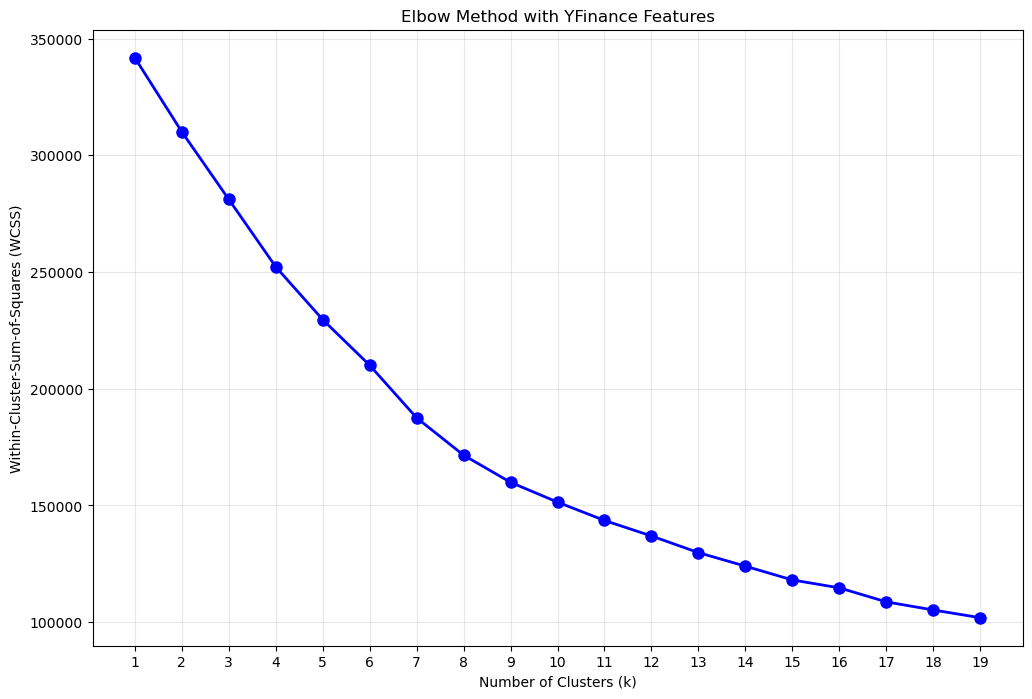


Performing K-means clustering with k=8...

CLUSTER PROFILES - FEATURE STATISTICS

CLUSTER CHARACTERISTICS (Mean Values):
--------------------------------------------------

--- CLUSTER 0 ---
Number of observations: 20360
  • Dominant insider level: 2
  • Large positive transactions (buying)
  • Moderate positive short-term returns
  • Neutral medium-term returns
  • Normal recent trading volume
  • Normal sustained trading volume

  Actual values:
    Level_1_count: 10.8478
    Level_2_count: 10.9797
    Level_3_count: 5.8623
    excess_return_7d: 0.0058
    excess_return_30d: 0.0211
    volume_zscore_30d: -0.1046
    volume_zscore_7d: -0.0318
    past_beta_60d: 0.7425
    NET_TRANSACTION: 8769117.5778

--- CLUSTER 1 ---
Number of observations: 9387
  • Dominant insider level: 1
  • Small negative transactions (moderate selling)
  • Strong positive short-term returns
  • Very strong medium-term returns
  • Normal recent trading volume
  • Normal sustained trading volume

  Actual valu

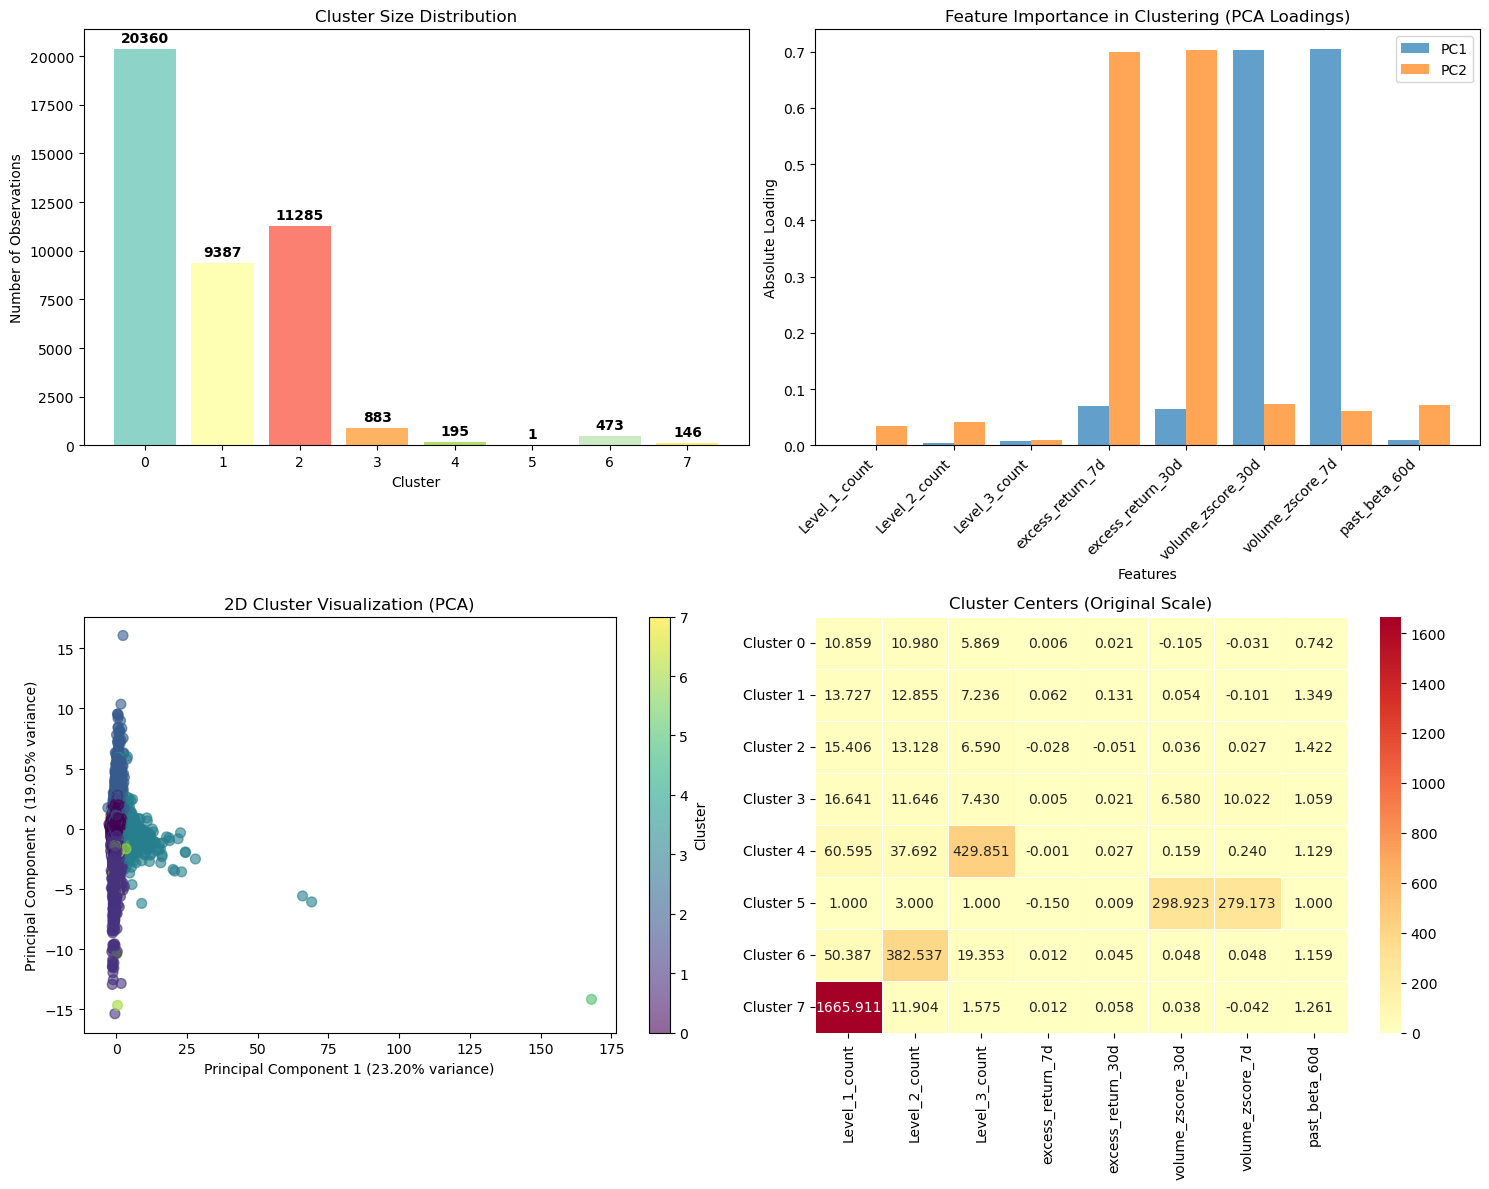


CLUSTER INTERPRETATIONS

Cluster 0: Level 2 insiders dominant | Moderate performing | Normal attention | Moderate buying
  Size: 20360 observations (47.6%)

Cluster 1: Level 1 insiders dominant | High performing | Normal attention | Small selling
  Size: 9387 observations (22.0%)

Cluster 2: Level 1 insiders dominant | Severely underperforming | Normal attention | Moderate selling
  Size: 11285 observations (26.4%)

Cluster 3: Level 1 insiders dominant | Moderate performing | High attention | Large buying
  Size: 883 observations (2.1%)

Cluster 4: Level 3 insiders dominant | Moderate performing | Normal attention | Large selling
  Size: 195 observations (0.5%)

Cluster 5: Level 2 insiders dominant | Severely underperforming | High attention | Large buying
  Size: 1 observations (0.0%)

Cluster 6: Level 2 insiders dominant | Moderate performing | Normal attention | Large buying
  Size: 473 observations (1.1%)

Cluster 7: Level 1 insiders dominant | High performing | Normal attention |

In [ ]:
# Use the final dataframe with features
df_cluster = grouped_df_features.copy()

if len(df_cluster) > 0:
    print("\nProceeding with clustering...")

    # 1. Select features (EXCLUDE NET_TRANSACTION from clustering features)
    features = [
        'Level_1_count', 'Level_2_count', 'Level_3_count',
        'excess_return_7d',
        'excess_return_30d',
        'volume_zscore_30d',
        'volume_zscore_7d',
        'past_beta_60d'
    ]

    # Check which features actually exist in the dataframe
    available_features = [f for f in features if f in df_cluster.columns]
    print(f"Available features for clustering: {available_features}")
    print(f"Missing features: {set(features) - set(available_features)}")
    
    if len(available_features) == 0:
        print("ERROR: No features available for clustering!")
    else:
        X = df_cluster[available_features].copy()
        
        # Check for NaN values in features
        nan_counts = X.isna().sum()
        if nan_counts.sum() > 0:
            print(f"Warning: Found NaN values in features:")
            for feature, count in nan_counts[nan_counts > 0].items():
                print(f"  {feature}: {count} NaN values")
            # Option: Fill NaN or drop rows
            X = X.dropna()
            print(f"After dropping NaN rows: {len(X)} samples remaining")
        
        if len(X) == 0:
            print("ERROR: No data remaining after NaN removal!")
        else:
            # 2. Scale
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X)

            # 3. Elbow Method
            wcss = []
            k_range = range(1, min(20, len(X_scaled)))

            print("Performing elbow method analysis...")
            for k in k_range:
                kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
                kmeans.fit(X_scaled)
                wcss.append(kmeans.inertia_)

            # Plot the elbow curve
            plt.figure(figsize=(12, 8))
            plt.plot(k_range, wcss, 'bo-', markersize=8, linewidth=2)
            plt.xlabel('Number of Clusters (k)')
            plt.ylabel('Within-Cluster-Sum-of-Squares (WCSS)')
            plt.title('Elbow Method with YFinance Features')
            plt.xticks(k_range)
            plt.grid(True, alpha=0.3)
            plt.show()

            # ===============================================
            # CLUSTER ANALYSIS - ADDED CODE
            # ===============================================
            
            # Determine optimal k from elbow curve
            optimal_k = 8 # Change this based on where the elbow bends
            
            print(f"\nPerforming K-means clustering with k={optimal_k}...")
            
            # Perform final clustering
            kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
            cluster_labels = kmeans_final.fit_predict(X_scaled)
            
            # Add cluster labels to dataframe (only for rows that were used in clustering)
            df_cluster_clean = df_cluster.loc[X.index].copy()
            df_cluster_clean['cluster'] = cluster_labels


            
            # ===============================================
            # 1. CLUSTER PROFILES - Feature Statistics
            # ===============================================
            
            print("\n" + "="*80)
            print("CLUSTER PROFILES - FEATURE STATISTICS")
            print("="*80)
            
            # Calculate cluster statistics for clustering features
            cluster_stats = df_cluster_clean.groupby('cluster')[available_features].agg(['mean', 'std', 'count'])
            
            # Display mean values for interpretation
            print("\nCLUSTER CHARACTERISTICS (Mean Values):")
            print("-" * 50)
            
            # Get means for ALL columns including NET_TRANSACTION for analysis
            all_analysis_columns = available_features + (['NET_TRANSACTION'] if 'NET_TRANSACTION' in df_cluster_clean.columns else [])
            cluster_means_all = df_cluster_clean.groupby('cluster')[all_analysis_columns].mean()
            
            for cluster in range(optimal_k):
                if cluster in cluster_means_all.index:
                    print(f"\n--- CLUSTER {cluster} ---")
                    cluster_size = len(df_cluster_clean[df_cluster_clean['cluster'] == cluster])
                    print(f"Number of observations: {cluster_size}")
                    
                    cluster_data = cluster_means_all.loc[cluster]
                    
                    # Interpret each feature
                    interpretations = []
                    
                    # Level counts (insider activity levels)
                    if all(lvl in cluster_data.index for lvl in ['Level_1_count', 'Level_2_count', 'Level_3_count']):
                        level_counts = [cluster_data['Level_1_count'], cluster_data['Level_2_count'], cluster_data['Level_3_count']]
                        dominant_level = np.argmax(level_counts) + 1
                        interpretations.append(f"Dominant insider level: {dominant_level}")

                    # NET_TRANSACTION analysis (only if column exists)
                    if 'NET_TRANSACTION' in cluster_data:
                        net_trans = cluster_data['NET_TRANSACTION']
                        if net_trans > 10_000_000:
                            interpretations.append("Very large positive transactions (strong buying)")
                        elif net_trans > 2_000_000:
                            interpretations.append("Large positive transactions (buying)")
                        elif net_trans < -10_000_000:
                            interpretations.append("Very large negative transactions (strong selling)")
                        elif net_trans < -2_000_000:
                            interpretations.append("Large negative transactions (selling)")
                        elif net_trans > 0:
                            interpretations.append("Small positive transactions (moderate buying)")
                        elif net_trans < 0:
                            interpretations.append("Small negative transactions (moderate selling)")
                        else:
                            interpretations.append("Balanced transactions")
                    
                    # Excess returns (7-day)
                    if 'excess_return_7d' in cluster_data:
                        r7 = cluster_data['excess_return_7d']

                        if r7 > 0.03:
                            interpretations.append("Strong positive short-term returns")
                        elif r7 > 0.005:
                            interpretations.append("Moderate positive short-term returns")
                        elif r7 < -0.016:
                            interpretations.append("Strong negative short-term returns")
                        elif r7 < -0.005:
                            interpretations.append("Moderate negative short-term returns")
                        else:
                            interpretations.append("Neutral short-term returns")

                    # Excess returns (30-day)
                    if 'excess_return_30d' in cluster_data:
                        r30 = cluster_data['excess_return_30d']

                        if r30 > 0.08:
                            interpretations.append("Very strong medium-term returns")
                        elif r30 > 0.03:
                            interpretations.append("Strong medium-term returns")
                        elif r30 < -0.03:
                            interpretations.append("Very weak medium-term returns")
                        elif r30 < -0.01:
                            interpretations.append("Weak medium-term returns")
                        else:
                            interpretations.append("Neutral medium-term returns")

                    
                    # Volume z-scores (check if columns exist)
                    # Volume z-scores (7d)
                    if 'volume_zscore_7d' in cluster_data:
                        z7 = cluster_data['volume_zscore_7d']
                        if z7 > 1.5:
                            interpretations.append("High recent trading volume spike")
                        elif z7 > 0.5:
                            interpretations.append("Moderately elevated recent trading volume")
                        elif z7 < -0.5:
                            interpretations.append("Unusually low recent trading volume")
                        else:
                            interpretations.append("Normal recent trading volume")

                    # Volume z-scores (30d)
                    if 'volume_zscore_30d' in cluster_data:
                        z30 = cluster_data['volume_zscore_30d']
                        if z30 > 1.2:
                            interpretations.append("Sustained high trading volume")
                        elif z30 > 0.4:
                            interpretations.append("Slightly elevated sustained trading volume")
                        elif z30 < -0.4:
                            interpretations.append("Sustained low trading volume")
                        else:
                            interpretations.append("Normal sustained trading volume")

                    
                    # Print interpretations
                    for interpretation in interpretations:
                        print(f"  • {interpretation}")
                    
                    # Print actual values
                    print(f"\n  Actual values:")
                    for feature in all_analysis_columns:
                        if feature in cluster_data:
                            print(f"    {feature}: {cluster_data[feature]:.4f}")
            
            # ============================================================
            # ADD CLUSTER LABELS BACK TO THE ORIGINAL MASTER DATAFRAME
            # ============================================================

            # Merge cluster labels back into grouped_df_features (align on index)
            grouped_df_features = grouped_df_features.merge(
                df_cluster_clean[['cluster']],
                left_index=True,
                right_index=True,
                how='left'
            )

            # Standardize naming
            grouped_df_features.rename(columns={'cluster': 'cluster_id'}, inplace=True)

            print("\nCluster labels successfully merged into grouped_df_features.")
            print(grouped_df_features['cluster_id'].value_counts().sort_index())



            # ===============================================
            # 2. VISUALIZATION - Cluster Distribution
            # ===============================================
            
            plt.figure(figsize=(15, 12))
            
            # Plot 1: Cluster distribution
            plt.subplot(2, 2, 1)
            cluster_counts = df_cluster_clean['cluster'].value_counts().sort_index()
            colors = plt.cm.Set3(np.linspace(0, 1, optimal_k))
            plt.bar(cluster_counts.index, cluster_counts.values, color=colors)
            plt.xlabel('Cluster')
            plt.ylabel('Number of Observations')
            plt.title('Cluster Size Distribution')
            plt.xticks(range(optimal_k))
            
            # Add count labels on bars
            for i, count in enumerate(cluster_counts.values):
                plt.text(i, count + max(cluster_counts.values)*0.01, str(count), 
                        ha='center', va='bottom', fontweight='bold')

            # ===============================================
            # 3. VISUALIZATION - Feature Importance by Cluster
            # ===============================================
            
            plt.subplot(2, 2, 2)
            
            # Use PCA to understand feature importance in clustering
            pca = PCA()
            X_pca = pca.fit_transform(X_scaled)
            
            # Feature importance from PCA
            feature_importance = np.abs(pca.components_[:2,:])  # First two components
            
            # Plot feature importance
            x_pos = np.arange(len(available_features))
            plt.bar(x_pos - 0.2, feature_importance[0], 0.4, label='PC1', alpha=0.7)
            plt.bar(x_pos + 0.2, feature_importance[1], 0.4, label='PC2', alpha=0.7)
            plt.xlabel('Features')
            plt.ylabel('Absolute Loading')
            plt.title('Feature Importance in Clustering (PCA Loadings)')
            plt.xticks(x_pos, available_features, rotation=45, ha='right')
            plt.legend()
            plt.tight_layout()

            # ===============================================
            # 4. VISUALIZATION - 2D Cluster Plot
            # ===============================================
            
            plt.subplot(2, 2, 3)
            
            # Use first two principal components for visualization
            scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, 
                                cmap='viridis', alpha=0.6, s=50)
            plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
            plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
            plt.title('2D Cluster Visualization (PCA)')
            plt.colorbar(scatter, label='Cluster')
            
            # ===============================================
            # 5. VISUALIZATION - Heatmap of Cluster Centers
            # ===============================================
            
            plt.subplot(2, 2, 4)
            
            # Get cluster centers in original feature space
            cluster_centers_original = scaler.inverse_transform(kmeans_final.cluster_centers_)
            cluster_center_df = pd.DataFrame(cluster_centers_original, 
                                        columns=available_features, 
                                        index=[f'Cluster {i}' for i in range(optimal_k)])
            
            # Create heatmap
            sns.heatmap(cluster_center_df, annot=True, cmap='RdYlBu_r', center=0,
                        fmt='.3f', linewidths=0.5)
            plt.title('Cluster Centers (Original Scale)')
            plt.tight_layout()
            
            plt.show()

            # ===============================================
            # 6. CLUSTER DESCRIPTIONS
            # ===============================================
            
            print("\n" + "="*80)
            print("CLUSTER INTERPRETATIONS")
            print("="*80)
            
            # Create descriptive names for each cluster based on characteristics
            cluster_descriptions = {}
            
            for cluster in range(optimal_k):
                if cluster in cluster_means_all.index:
                    cluster_data = cluster_means_all.loc[cluster]
                    
                    # Build description based on feature patterns
                    description_parts = []
                    
                    # Insider activity pattern
                    if all(lvl in cluster_data.index for lvl in ['Level_1_count', 'Level_2_count', 'Level_3_count']):
                        level_pattern = ""
                        level_values = [cluster_data['Level_1_count'], cluster_data['Level_2_count'], cluster_data['Level_3_count']]
                        if max(level_values) == level_values[0]:
                            level_pattern = "Level 1 insiders dominant"
                        elif max(level_values) == level_values[1]:
                            level_pattern = "Level 2 insiders dominant"
                        else:
                            level_pattern = "Level 3 insiders dominant"
                        description_parts.append(level_pattern)
                    
                    # Return pattern
                    if all(ret in cluster_data.index for ret in ['excess_return_7d', 'excess_return_30d']):
                        avg_return = (cluster_data['excess_return_7d'] + cluster_data['excess_return_30d']) / 2
                        if avg_return > 0.03:
                            return_pattern = "High performing"
                        elif avg_return > 0:
                            return_pattern = "Moderate performing"
                        elif avg_return > -0.03:
                            return_pattern = "Underperforming"
                        else:
                            return_pattern = "Severely underperforming"
                        description_parts.append(return_pattern)
                    
                    # Volume pattern
                    if all(vol in cluster_data.index for vol in ['volume_zscore_7d', 'volume_zscore_30d']):
                        avg_volume = (cluster_data['volume_zscore_7d'] + cluster_data['volume_zscore_30d']) / 2
                        if avg_volume > 1:
                            volume_pattern = "High attention"
                        elif avg_volume > -1:
                            volume_pattern = "Normal attention"
                        else:
                            volume_pattern = "Low attention"
                        description_parts.append(volume_pattern)
                    
                    # Transaction size pattern (only if NET_TRANSACTION exists)
                    if 'NET_TRANSACTION' in cluster_data:
                        net_trans = cluster_data['NET_TRANSACTION']
                        if net_trans > 10_000_000:
                            trans_pattern = "Large buying"
                        elif net_trans > 2_000_000:
                            trans_pattern = "Moderate buying"
                        elif net_trans < -10_000_000:
                            trans_pattern = "Large selling"
                        elif net_trans < -2_000_000:
                            trans_pattern = "Moderate selling"
                        elif net_trans > 0:
                            trans_pattern = "Small buying"
                        elif net_trans < 0:
                            trans_pattern = "Small selling"
                        else:
                            trans_pattern = "Balanced"
                        description_parts.append(trans_pattern)

                    cluster_descriptions[cluster] = " | ".join(description_parts)
                    
                    cluster_size = len(df_cluster_clean[df_cluster_clean['cluster'] == cluster])
                    print(f"\nCluster {cluster}: {cluster_descriptions[cluster]}")
                    print(f"  Size: {cluster_size} observations ({cluster_size/len(df_cluster_clean)*100:.1f}%)")
            
            # ===============================================
            # 7. INVESTMENT IMPLICATIONS
            # ===============================================
            
            print("\n" + "="*80)
            print("POTENTIAL INVESTMENT INTERPRETATIONS")
            print("="*80)
            
            interpretations = {
                "High performing + High attention": "Potential momentum plays with strong insider activity",
                "High performing + Low attention": "Undervalued opportunities with positive insider signals",
                "Underperforming + High attention": "High-risk situations, possibly value traps or turnarounds",
                "Underperforming + Low attention": "Avoid - weak performance with little interest",
                "Level 1 insiders dominant": "Senior executive activity - typically stronger signals",
                "Level 3 insiders dominant": "General insider activity - monitor for patterns",
                "Large buying": "Strong insider conviction in buying",
                "Large selling": "Strong insider conviction in selling"
            }
            
            for key, value in interpretations.items():
                matching_clusters = [f"Cluster {c}" for c, desc in cluster_descriptions.items() if key in desc]
                if matching_clusters:
                    print(f"• {key}: {value} → Found in: {', '.join(matching_clusters)}")
            
            # Update the original df_cluster with results
            df_cluster = df_cluster_clean

else:
    print("No data available for clustering after feature extraction.")

In [331]:
#Method 1 - Hierarchical Clustering of Cluster Centers 
#Clusters are robust since all 4 methods lead to the same clusters
#But, difficult to interpret further than KMeans above

from scipy.cluster.hierarchy import linkage, fcluster

methods = ["ward", "complete", "average", "centroid"]

for m in methods:
    Z = linkage(kmeans_final.cluster_centers_, method=m)
    print(m, fcluster(Z, 3, criterion='maxclust'))

ward [1 1 1 1 1 3 1 2]
complete [1 1 1 1 1 3 1 2]
average [1 1 1 1 1 3 1 2]
centroid [1 1 1 1 1 3 1 2]


**Cluster Summary (Buying/Selling)**

- Buy-dominant clusters: Clusters with moderate/large positive transactions
→ Clusters 0, 3, 5, 6

- Sell-dominant clusters: Clusters with moderate/large negative transactions
→ Clusters 1, 2, 4

- Neutral clusters: Clusters with small/moderate positive or negative transactions, moderate size, not clearly buy/sell
→ Could be Cluster 0 if you want to treat moderate buying as “neutral” instead of “buy”

In [76]:
grouped_df_features.columns

Index(['FILING_DATE', 'ISSUERTRADINGSYMBOL', 'TRANS_SHARES_SIGN',
       'price_report', 'Days_Diff', 'return_t_to_t5', 'return_t_to_t21',
       'return_t_to_t45', 'return_t_to_t60', 'return_t_to_t90',
       'return_t_to_t120', 'return_t_to_t252', 'return_r_to_r5',
       'return_r_to_r21', 'return_r_to_r45', 'return_r_to_r60',
       'return_r_to_r90', 'return_r_to_r120', 'return_r_to_r252',
       'relative_return_t_to_t5', 'relative_return_r_to_r5',
       'relative_return_t_to_t21', 'relative_return_r_to_r21',
       'relative_return_t_to_t45', 'relative_return_r_to_r45',
       'relative_return_t_to_t60', 'relative_return_r_to_r60',
       'relative_return_t_to_t90', 'relative_return_r_to_r90',
       'relative_return_t_to_t120', 'relative_return_r_to_r120',
       'relative_return_t_to_t252', 'relative_return_r_to_r252',
       'Level_1_count', 'Level_2_count', 'Level_3_count', 'NET_TRANSACTION',
       'excess_return_7d', 'excess_return_30d', 'volume_zscore_30d',
       'volum

In [391]:
buy_clusters = [3, 5, 6]
sell_clusters = [1, 2, 4, 7]
neutral_clusters = [0]

df_buy = grouped_df_features[grouped_df_features['cluster_id'].isin(buy_clusters)].copy()
df_sell = grouped_df_features[grouped_df_features['cluster_id'].isin(sell_clusters)].copy()
df_neutral = grouped_df_features[grouped_df_features['cluster_id'].isin(neutral_clusters)].copy()

- Level 1 insiders dominant: Senior executive activity - typically stronger signals → Found in: Cluster 1, Cluster 2, Cluster 3, Cluster 7
- Level 3 insiders dominant: General insider activity - monitor for patterns → Found in: Cluster 4

In [392]:
level_1_clusters = [1, 2, 3, 7]
level_3_clusters = [4]
others = [5, 6, 0]

df_l1 = grouped_df_features[grouped_df_features['cluster_id'].isin(level_1_clusters)].copy()
df_l3 = grouped_df_features[grouped_df_features['cluster_id'].isin(level_3_clusters)].copy()
df_l2 = grouped_df_features[grouped_df_features['cluster_id'].isin(others)].copy()

In [83]:
df_buy.columns

Index(['FILING_DATE', 'ISSUERTRADINGSYMBOL', 'TRANS_SHARES_SIGN',
       'price_report', 'Days_Diff', 'return_t_to_t5', 'return_t_to_t21',
       'return_t_to_t45', 'return_t_to_t60', 'return_t_to_t90',
       'return_t_to_t120', 'return_t_to_t252', 'return_r_to_r5',
       'return_r_to_r21', 'return_r_to_r45', 'return_r_to_r60',
       'return_r_to_r90', 'return_r_to_r120', 'return_r_to_r252',
       'relative_return_t_to_t5', 'relative_return_r_to_r5',
       'relative_return_t_to_t21', 'relative_return_r_to_r21',
       'relative_return_t_to_t45', 'relative_return_r_to_r45',
       'relative_return_t_to_t60', 'relative_return_r_to_r60',
       'relative_return_t_to_t90', 'relative_return_r_to_r90',
       'relative_return_t_to_t120', 'relative_return_r_to_r120',
       'relative_return_t_to_t252', 'relative_return_r_to_r252',
       'Level_1_count', 'Level_2_count', 'Level_3_count', 'NET_TRANSACTION',
       'excess_return_7d', 'excess_return_30d', 'volume_zscore_30d',
       'volum

In [363]:
len(df_buy), len(df_sell), len(df_neutral)

(1357, 20867, 20360)

In [393]:
# try regressions with merged clusters - are the coeff and p-values better in some clusters

def running_regression(df, ff):
    df = df.copy()
    df["FILING_DATE"] = pd.to_datetime(df["FILING_DATE"])
    df_events = df.merge(ff, left_on='FILING_DATE', right_on='Date', how='left')
    df_events['excess_r5'] = df_events['return_r_to_r21'] - df_events['cum_RF']
    df_events['insider_signal'] = np.sign(df_events['TRANS_SHARES_SIGN'])   
    results = run_multiple_specifications(df_events)
    return results

results_buy = running_regression(df_buy, ff)



Basic:
  Insider coef: -0.008756
  P-value: 0.0164

With_FF3:
  Insider coef: -0.008589
  P-value: 0.0066

With_FE:
  Insider coef: -0.006814
  P-value: 0.0701

With_FE_Time:
  Insider coef: -0.005756
  P-value: 0.1262


In [394]:
results = running_regression(df_sell, ff)



Basic:
  Insider coef: -0.002913
  P-value: 0.0002

With_FF3:
  Insider coef: -0.001651
  P-value: 0.0133

With_FE:
  Insider coef: 0.001291
  P-value: 0.0727

With_FE_Time:
  Insider coef: 0.001499
  P-value: 0.0375


In [395]:
results = running_regression(df_neutral, ff)



Basic:
  Insider coef: 0.000565
  P-value: 0.3107

With_FF3:
  Insider coef: 0.000408
  P-value: 0.4123

With_FE:
  Insider coef: 0.001247
  P-value: 0.0157

With_FE_Time:
  Insider coef: 0.001183
  P-value: 0.0226


In [396]:
len(df_l1), len(df_l2), len(df_l3)

(21701, 20834, 195)

In [397]:
df_l1.columns

Index(['FILING_DATE', 'ISSUERTRADINGSYMBOL', 'TRANS_SHARES_SIGN',
       'price_report', 'Days_Diff', 'return_t_to_t5', 'return_t_to_t21',
       'return_t_to_t45', 'return_t_to_t60', 'return_t_to_t90',
       'return_t_to_t120', 'return_t_to_t252', 'return_r_to_r5',
       'return_r_to_r21', 'return_r_to_r45', 'return_r_to_r60',
       'return_r_to_r90', 'return_r_to_r120', 'return_r_to_r252',
       'relative_return_t_to_t5', 'relative_return_r_to_r5',
       'relative_return_t_to_t21', 'relative_return_r_to_r21',
       'relative_return_t_to_t45', 'relative_return_r_to_r45',
       'relative_return_t_to_t60', 'relative_return_r_to_r60',
       'relative_return_t_to_t90', 'relative_return_r_to_r90',
       'relative_return_t_to_t120', 'relative_return_r_to_r120',
       'relative_return_t_to_t252', 'relative_return_r_to_r252',
       'Level_1_count', 'Level_2_count', 'Level_3_count', 'NET_TRANSACTION',
       'excess_return_7d', 'excess_return_30d', 'volume_zscore_30d',
       'volum

In [398]:
df_l1.TRANS_SHARES_SIGN

0          104874.00
1          283500.00
2          113940.00
3          903128.67
4           70000.00
            ...     
43770       -8000.00
43771   -37941612.00
43774      -17000.00
43775      -52409.00
43776       -1050.00
Name: TRANS_SHARES_SIGN, Length: 21701, dtype: float64

In [399]:
results = running_regression(df_l1, ff)



Basic:
  Insider coef: -0.003153
  P-value: 0.0000

With_FF3:
  Insider coef: -0.001845
  P-value: 0.0049

With_FE:
  Insider coef: 0.001088
  P-value: 0.1243

With_FE_Time:
  Insider coef: 0.001298
  P-value: 0.0670


In [400]:
results = running_regression(df_l3, ff)


Basic:
  Insider coef: -0.003336
  P-value: 0.6848

With_FF3:
  Insider coef: -0.005631
  P-value: 0.4845

With_FE:
  Insider coef: -0.003940
  P-value: 0.6567

With_FE_Time:
  Insider coef: 0.001875
  P-value: 0.8335


In [401]:
results = running_regression(df_l2, ff)


Basic:
  Insider coef: 0.000320
  P-value: 0.5656

With_FF3:
  Insider coef: 0.000193
  P-value: 0.6983

With_FE:
  Insider coef: 0.001045
  P-value: 0.0431

With_FE_Time:
  Insider coef: 0.000985
  P-value: 0.0580


### Public Attention Proxy

- Add momentum (7, 30)
- Add volume z-score (7, 30)
- 60-day volatility
- Market beta

#### Base Strategy

In [ ]:
# Step 0: Prepare the Data
df = pd.read_csv("Insider_Trading_Features.csv")
df['FILING_DATE'] = pd.to_datetime(df['FILING_DATE'])
df['week'] = df['FILING_DATE'].dt.to_period('W').dt.start_time

# Features for score
features = ['NET_TRANSACTION', 'excess_return_30d', 'volume_zscore_30d',
            'Level_1_count', 'Level_2_count', 'Level_3_count']
df = df[df['FILING_DATE'] >= '2006-01-01'].copy()
weeks = sorted(df[df['FILING_DATE'].dt.year >= 2010]['week'].unique())
score_records = []
weekly_returns = []
for current_week in tqdm(weeks):
    train_data = df[df['week'] < current_week]
    if train_data.empty:
        continue
    test_data = df[df['week'] == current_week].copy()
    stats = train_data.groupby('ISSUERTRADINGSYMBOL')[features].agg(['mean', 'std'])
    
    stats.columns = ['_'.join(col) for col in stats.columns]
    stats = stats.reset_index()
    test_data = test_data.merge(stats, on='ISSUERTRADINGSYMBOL', how='left')
    for col in features:
        test_data[f'z_{col}'] = (
            test_data[col] - test_data[f'{col}_mean']
        ) / test_data[f'{col}_std']

    # Calculate Public Score
    test_data['public_score'] = (
        test_data['z_NET_TRANSACTION'] +
        test_data['z_excess_return_30d'] +
        test_data['z_volume_zscore_30d'] +
        test_data['z_Level_1_count'] 
        #  + 0.25 * test_data['z_Level_2_count'] +
        #  0.15 * test_data['z_Level_3_count']
    )

    test_data['score_rank'] = test_data['public_score'].rank(ascending=False)
    score_records.append(
        test_data[['FILING_DATE', 'ISSUERTRADINGSYMBOL', 'public_score', 'score_rank',
                   'relative_return_r_to_r5', 'relative_return_r_to_r21']]
    )

    # Weekly long-short simulation
    trade_data = test_data.dropna(subset=['relative_return_r_to_r5', 'relative_return_r_to_r21'])

    if len(trade_data) < 30:
        continue
    sorted_data = trade_data.sort_values('public_score', ascending=False)

    # Long top 15
    long_5d = sorted_data.head(int(len(trade_data)*0.2))['relative_return_r_to_r5'].mean()
    long_21d = sorted_data.head(int(len(trade_data)*0.2))['relative_return_r_to_r21'].mean()

    # Short bottom 15
    short_5d = sorted_data.tail(int(len(trade_data)*0.2))['relative_return_r_to_r5'].mean()
    short_21d = sorted_data.tail(int(len(trade_data)*0.2))['relative_return_r_to_r21'].mean()

    # Long-Short Return
    long_short_5d = long_5d - short_5d
    long_short_21d = long_21d - short_21d

    weekly_returns.append({
        'week': current_week,
        'long_5d': long_5d,
        'short_5d': short_5d,
        'long_short_5d': long_short_5d,
        'long_21d': long_21d,
        'short_21d': short_21d,
        'long_short_21d': long_short_21d
    })

# Final DataFrames
score_df = pd.concat(score_records).reset_index(drop=True)
returns_df = pd.DataFrame(weekly_returns)

# Summary stats
avg_5d = returns_df['long_short_5d'].mean()
avg_21d = returns_df['long_short_21d'].mean()

print(f"\n Average Long-Short Return (5-day):  {avg_5d * 100:.2f}%")
print(f" Average Long-Short Return (21-day): {avg_21d * 100:.2f}%")

In [ ]:
# Weekly excess returns (long-short)
weekly_5d = returns_df['long_short_5d']
weekly_21d = returns_df['long_short_21d']

# Sharpe ratios (annualized)
sharpe_5d = (weekly_5d.mean() / weekly_5d.std()) * np.sqrt(52)
sharpe_21d = (weekly_21d.mean() / weekly_21d.std()) * np.sqrt(52)

print(f"\n Sharpe Ratio (5-day long-short):  {sharpe_5d:.2f}")
print(f" Sharpe Ratio (21-day long-short): {sharpe_21d:.2f}")
net_txn_weekly_returns = []

for current_week in tqdm(weeks):
    test_data = df[df['week'] == current_week].copy()
    trade_data = test_data.dropna(subset=['relative_return_r_to_r5', 'relative_return_r_to_r21'])

    if len(trade_data) < 30:
        continue

    # Rank by raw NET_TRANSACTION (higher = more buying)
    trade_data = trade_data.dropna(subset=['NET_TRANSACTION'])
    trade_data = trade_data[trade_data['Level_1_count'] >= trade_data['Level_2_count'] + trade_data['Level_3_count']]
    sorted_data = trade_data.sort_values('NET_TRANSACTION', ascending=False)

    top_n = int(len(trade_data) * 0.20)

    # Long top 15%
    long_5d = sorted_data.head(top_n)['relative_return_r_to_r5'].mean()
    long_21d = sorted_data.head(top_n)['relative_return_r_to_r21'].mean()

    # Short bottom 15%
    short_5d = sorted_data.tail(top_n)['relative_return_r_to_r5'].mean()
    short_21d = sorted_data.tail(top_n)['relative_return_r_to_r21'].mean()

    net_txn_weekly_returns.append({
        'week': current_week,
        'long_5d': long_5d,
        'short_5d': short_5d,
        'long_short_5d': long_5d - short_5d,
        'long_21d': long_21d,
        'short_21d': short_21d,
        'long_short_21d': long_21d - short_21d
    })

# Convert to DataFrame
net_txn_returns_df = pd.DataFrame(net_txn_weekly_returns)

# Summary statistics
net_txn_avg_5d = net_txn_returns_df['long_short_5d'].mean()
net_txn_avg_21d = net_txn_returns_df['long_short_21d'].mean()

print(f"\n NET_TRANSACTION Only — Average Long-Short Return (5-day):  {net_txn_avg_5d * 100:.2f}%")
print(f" NET_TRANSACTION Only — Average Long-Short Return (21-day): {net_txn_avg_21d * 100:.2f}%")

In [ ]:
# === Sharpe Ratio Calculation ===============================================

# Weekly excess returns (long-short)
weekly_5d = net_txn_returns_df['long_short_5d']
weekly_21d = net_txn_returns_df['long_short_21d']

# Sharpe ratios (annualized)
sharpe_5d = (weekly_5d.mean() / weekly_5d.std()) * np.sqrt(52)
sharpe_21d = (weekly_21d.mean() / weekly_21d.std()) * np.sqrt(52)

print(f"\n Sharpe Ratio (5-day long-short):  {sharpe_5d:.2f}")
print(f" Sharpe Ratio (21-day long-short): {sharpe_21d:.2f}")

#### Base Strategy with Improvements

Dealing with potential data leakage: The test-stats are being calculated on the past data (everything preceeding the current week), but there is a chance of survivorship bias and lookahead bias in the aggregation.

Problem 1 - Stocks that don't exist in the training period. In such cases, if a stock appears for the first time in the test data but has no history in train_data then the merge will create NaN values for all columns.

Problem 2 - Using stock-specific history that may not be available in real-time. May not have the complete historical profile for each stock at the time of trading. Some stocks may be delisted, statistical properties may change with time, new stocks IPO and may have limited history.

Fixing the data leakage, performing significance testing, adding transaction costs, making plots, comparing rebalancing, weekly reb. for 5-day strat and monthly rebalancing for 7-day strat

This next code block was weekly rebelancing both the strategies; next one is correct. Weekly rebalancing for 5-day strategy and monthly rebalancing for 21-day.

In [ ]:
# import pandas as pd
# import numpy as np
# from scipy import stats
# from tqdm import tqdm
# import matplotlib.pyplot as plt
# import seaborn as sns

# # ============================================================================
# # CONFIGURATION & DATA LOADING
# # ============================================================================

# # Constants
# FEATURES = ['NET_TRANSACTION', 'excess_return_30d', 'volume_zscore_30d', 
#             'Level_1_count', 'Level_2_count', 'Level_3_count']
# TOP_PCT = 0.2
# COST_BPS = 10

# def load_and_prepare_data(file_path):
#     """Load and prepare the base dataset"""
#     df = pd.read_csv(file_path)
#     df['FILING_DATE'] = pd.to_datetime(df['FILING_DATE'])
#     df['week'] = df['FILING_DATE'].dt.to_period('W').dt.start_time
#     df = df[df['FILING_DATE'] >= '2006-01-01'].copy()
#     return df

# # ============================================================================
# # CORE STRATEGY FUNCTIONS
# # ============================================================================

# def calculate_z_scores(train_data, test_data, features):
#     """Calculate z-scores for features using market-wide statistics"""
#     market_means = train_data[features].mean()
#     market_stds = train_data[features].std()
    
#     for col in features:
#         test_data[f'z_{col}'] = (test_data[col] - market_means[col]) / market_stds[col]
    
#     return test_data

# def create_portfolio(data, score_col, top_pct=0.2, min_stocks=5):
#     """Create equal-weighted long-short portfolio"""
#     if len(data) < min_stocks:
#         return None
    
#     # Remove extreme outliers
#     q_low = data[score_col].quantile(0.01)
#     q_high = data[score_col].quantile(0.99)
#     filtered_data = data[(data[score_col] >= q_low) & (data[score_col] <= q_high)]
    
#     if len(filtered_data) < min_stocks:
#         filtered_data = data
    
#     sorted_data = filtered_data.sort_values(score_col, ascending=False)
#     n_stocks = max(1, int(len(sorted_data) * top_pct))
    
#     if len(sorted_data) < 2 * n_stocks:
#         n_stocks = max(1, len(sorted_data) // 2)
    
#     long_portfolio = sorted_data.head(n_stocks)
#     short_portfolio = sorted_data.tail(n_stocks)
    
#     return {
#         'long_5d': long_portfolio['relative_return_r_to_r5'].mean(),
#         'short_5d': short_portfolio['relative_return_r_to_r5'].mean(),
#         'long_short_5d': long_portfolio['relative_return_r_to_r5'].mean() - short_portfolio['relative_return_r_to_r5'].mean(),
#         'long_21d': long_portfolio['relative_return_r_to_r21'].mean(),
#         'short_21d': short_portfolio['relative_return_r_to_r21'].mean(),
#         'long_short_21d': long_portfolio['relative_return_r_to_r21'].mean() - short_portfolio['relative_return_r_to_r21'].mean(),
#         'n_long': n_stocks,
#         'n_short': n_stocks,
#         'long_stocks': long_portfolio['ISSUERTRADINGSYMBOL'].tolist(),  # Track which stocks
#         'short_stocks': short_portfolio['ISSUERTRADINGSYMBOL'].tolist()  # Track which stocks
#     }

# def run_strategy_backtest(df, weeks, strategy_type="public_score"):
#     """Run backtest for a given strategy"""
#     weekly_returns = []
    
#     for current_week in tqdm(weeks, desc=f"Backtesting {strategy_type}"):
#         train_start = current_week - pd.Timedelta(weeks=52)
#         train_data = df[(df['week'] >= train_start) & (df['week'] < current_week)]
        
#         if train_data.empty:
#             continue

#         test_data = df[df['week'] == current_week].copy()
#         trade_data = test_data.dropna(subset=['relative_return_r_to_r5', 'relative_return_r_to_r21'])
        
#         if len(trade_data) < 30:
#             continue

#         if strategy_type == "public_score":
#             # Public Score Strategy
#             test_data = calculate_z_scores(train_data, test_data, FEATURES)
#             test_data['public_score'] = (
#                 test_data['z_NET_TRANSACTION'] +
#                 0.5*test_data['z_Level_1_count'] + 0.3*test_data['z_Level_2_count'] + 0.2*test_data['z_Level_3_count']
#             )
#             portfolio_result = create_portfolio(test_data, 'public_score', TOP_PCT)
            
#         elif strategy_type == "net_transaction":
#             # NET_TRANSACTION Only Strategy
#             #trade_data = trade_data[trade_data['Level_1_count'] >= 
#             #                     trade_data['Level_2_count'] + trade_data['Level_3_count']]
            
#             #trade_data = trade_data[trade_data['Level_1_count'] > 0]
#             market_mean = train_data['NET_TRANSACTION'].mean()
#             market_std = train_data['NET_TRANSACTION'].std()
#             trade_data['net_txn_z'] = (trade_data['NET_TRANSACTION'] - market_mean) / market_std if market_std > 0 else 0
            
#             portfolio_result = create_portfolio(trade_data, 'net_txn_z', TOP_PCT)

#         if portfolio_result is not None:
#             weekly_returns.append({
#                 'week': current_week,
#                 **portfolio_result
#             })
    
#     return pd.DataFrame(weekly_returns)

# # ============================================================================
# # PERFORMANCE ANALYSIS FUNCTIONS
# # ============================================================================

# def calculate_performance_stats(returns_series, risk_free_rate=0.0):
#     """Calculate comprehensive performance statistics"""
#     if len(returns_series) == 0:
#         return None
        
#     excess_returns = returns_series - (risk_free_rate / 52)
    
#     # Basic metrics
#     mean_return = returns_series.mean()
#     std_dev = returns_series.std()
#     sharpe_ratio = (excess_returns.mean() / excess_returns.std()) * np.sqrt(52) if excess_returns.std() > 0 else 0
    
#     # Statistical significance
#     t_stat, p_value = stats.ttest_1samp(returns_series, 0)
    
#     # Additional metrics
#     win_rate = (returns_series > 0).mean()
    
#     # Drawdown analysis
#     cumulative_returns = (1 + returns_series).cumprod()
#     running_max = cumulative_returns.expanding().max()
#     drawdowns = (cumulative_returns - running_max) / running_max
#     max_drawdown = drawdowns.min()
    
#     return {
#         'mean_return': mean_return,
#         'std_dev': std_dev,
#         'sharpe_ratio': sharpe_ratio,
#         't_statistic': t_stat,
#         'p_value': p_value,
#         'win_rate': win_rate,
#         'max_drawdown': max_drawdown,
#         'annualized_return': mean_return * 52,
#         'total_weeks': len(returns_series),
#         'positive_weeks': (returns_series > 0).sum()
#     }

# def apply_transaction_costs(returns_series, cost_bps=10):
#     """Apply transaction costs to returns"""
#     return returns_series - (cost_bps / 10000)

# # ============================================================================
# # VISUALIZATION AND REBALANCING ANALYSIS
# # ============================================================================

# def plot_strategy_comparison(public_score_returns, net_txn_returns):
#     """Create comprehensive time series plots comparing both strategies"""
    
#     # Ensure both dataframes have the same weeks and are sorted
#     common_weeks = sorted(set(public_score_returns['week']).intersection(set(net_txn_returns['week'])))
#     public_score_returns = public_score_returns[public_score_returns['week'].isin(common_weeks)].sort_values('week')
#     net_txn_returns = net_txn_returns[net_txn_returns['week'].isin(common_weeks)].sort_values('week')
    
#     # Create the plots
#     fig, axes = plt.subplots(3, 2, figsize=(16, 12))
#     fig.suptitle('Strategy Performance Comparison Over Time', fontsize=16, fontweight='bold')
    
#     # Plot 1: Cumulative Returns (5-day)
#     cumulative_public_5d = (1 + public_score_returns['long_short_5d']).cumprod() - 1
#     cumulative_net_5d = (1 + net_txn_returns['long_short_5d']).cumprod() - 1
    
#     axes[0, 0].plot(public_score_returns['week'], cumulative_public_5d * 100, 
#                    label='Public Score Strategy', linewidth=2, color='blue')
#     axes[0, 0].plot(net_txn_returns['week'], cumulative_net_5d * 100, 
#                    label='NET_TRANSACTION Only', linewidth=2, color='red', alpha=0.7)
#     axes[0, 0].set_title('Cumulative Returns - 5 Day Horizon')
#     axes[0, 0].set_ylabel('Cumulative Return (%)')
#     axes[0, 0].legend()
#     axes[0, 0].grid(True, alpha=0.3)
#     axes[0, 0].tick_params(axis='x', rotation=45)
    
#     # Plot 2: Cumulative Returns (21-day)
#     cumulative_public_21d = (1 + public_score_returns['long_short_21d']).cumprod() - 1
#     cumulative_net_21d = (1 + net_txn_returns['long_short_21d']).cumprod() - 1
    
#     axes[0, 1].plot(public_score_returns['week'], cumulative_public_21d * 100, 
#                    label='Public Score Strategy', linewidth=2, color='blue')
#     axes[0, 1].plot(net_txn_returns['week'], cumulative_net_21d * 100, 
#                    label='NET_TRANSACTION Only', linewidth=2, color='red', alpha=0.7)
#     axes[0, 1].set_title('Cumulative Returns - 21 Day Horizon')
#     axes[0, 1].set_ylabel('Cumulative Return (%)')
#     axes[0, 1].legend()
#     axes[0, 1].grid(True, alpha=0.3)
#     axes[0, 1].tick_params(axis='x', rotation=45)
    
#     # Plot 3: Rolling Sharpe Ratio (26-week window)
#     window = 26
#     rolling_sharpe_public_5d = (public_score_returns['long_short_5d'].rolling(window).mean() / 
#                                public_score_returns['long_short_5d'].rolling(window).std()) * np.sqrt(52)
#     rolling_sharpe_net_5d = (net_txn_returns['long_short_5d'].rolling(window).mean() / 
#                             net_txn_returns['long_short_5d'].rolling(window).std()) * np.sqrt(52)
    
#     axes[1, 0].plot(public_score_returns['week'], rolling_sharpe_public_5d, 
#                    label='Public Score Strategy', linewidth=2, color='blue')
#     axes[1, 0].plot(net_txn_returns['week'], rolling_sharpe_net_5d, 
#                    label='NET_TRANSACTION Only', linewidth=2, color='red', alpha=0.7)
#     axes[1, 0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
#     axes[1, 0].set_title(f'Rolling Sharpe Ratio ({window}-week window) - 5 Day')
#     axes[1, 0].set_ylabel('Sharpe Ratio')
#     axes[1, 0].legend()
#     axes[1, 0].grid(True, alpha=0.3)
#     axes[1, 0].tick_params(axis='x', rotation=45)
    
#     # Plot 4: Drawdowns
#     def calculate_drawdowns(cumulative_returns):
#         running_max = cumulative_returns.expanding().max()
#         drawdown = (cumulative_returns - running_max) / running_max
#         return drawdown
    
#     drawdown_public_5d = calculate_drawdowns(1 + cumulative_public_5d)
#     drawdown_net_5d = calculate_drawdowns(1 + cumulative_net_5d)
    
#     axes[1, 1].fill_between(public_score_returns['week'], drawdown_public_5d * 100, 0, 
#                            alpha=0.6, color='blue', label='Public Score Strategy')
#     axes[1, 1].fill_between(net_txn_returns['week'], drawdown_net_5d * 100, 0, 
#                            alpha=0.6, color='red', label='NET_TRANSACTION Only')
#     axes[1, 1].set_title('Drawdowns - 5 Day Horizon')
#     axes[1, 1].set_ylabel('Drawdown (%)')
#     axes[1, 1].legend()
#     axes[1, 1].grid(True, alpha=0.3)
#     axes[1, 1].tick_params(axis='x', rotation=45)
    
#     # Plot 5: Weekly Returns Distribution
#     axes[2, 0].hist(public_score_returns['long_short_5d'] * 100, bins=50, alpha=0.7, 
#                    label='Public Score Strategy', color='blue', density=True)
#     axes[2, 0].hist(net_txn_returns['long_short_5d'] * 100, bins=50, alpha=0.7, 
#                    label='NET_TRANSACTION Only', color='red', density=True)
#     axes[2, 0].axvline(x=0, color='black', linestyle='--', alpha=0.5)
#     axes[2, 0].set_title('Weekly Returns Distribution - 5 Day')
#     axes[2, 0].set_xlabel('Weekly Return (%)')
#     axes[2, 0].set_ylabel('Density')
#     axes[2, 0].legend()
#     axes[2, 0].grid(True, alpha=0.3)
    
#     # Plot 6: Rolling Win Rate (26-week window)
#     rolling_win_public = public_score_returns['long_short_5d'].rolling(window).apply(
#         lambda x: (x > 0).mean(), raw=True) * 100
#     rolling_win_net = net_txn_returns['long_short_5d'].rolling(window).apply(
#         lambda x: (x > 0).mean(), raw=True) * 100
    
#     axes[2, 1].plot(public_score_returns['week'], rolling_win_public, 
#                    label='Public Score Strategy', linewidth=2, color='blue')
#     axes[2, 1].plot(net_txn_returns['week'], rolling_win_net, 
#                    label='NET_TRANSACTION Only', linewidth=2, color='red', alpha=0.7)
#     axes[2, 1].axhline(y=50, color='black', linestyle='--', alpha=0.5, label='Break-even')
#     axes[2, 1].set_title(f'Rolling Win Rate ({window}-week window) - 5 Day')
#     axes[2, 1].set_ylabel('Win Rate (%)')
#     axes[2, 1].set_ylim(0, 100)
#     axes[2, 1].legend()
#     axes[2, 1].grid(True, alpha=0.3)
#     axes[2, 1].tick_params(axis='x', rotation=45)
    
#     plt.tight_layout()
#     plt.show()
    
#     return {
#         'common_weeks': common_weeks,
#         'cumulative_public_5d': cumulative_public_5d,
#         'cumulative_net_5d': cumulative_net_5d
#     }

# def analyze_rebalancing(public_score_returns, net_txn_returns):
#     """Analyze portfolio turnover and rebalancing requirements"""
#     print("\n" + "="*60)
#     print("REBALANCING ANALYSIS")
#     print("="*60)
    
#     # Calculate portfolio turnover (simplified)
#     # For a more accurate turnover, we'd need the full portfolio history
#     # This analysis uses the number of stocks as a proxy for turnover
    
#     # Public Score Strategy rebalancing
#     public_avg_long = public_score_returns['n_long'].mean()
#     public_avg_short = public_score_returns['n_short'].mean()
#     public_total_positions = public_avg_long + public_avg_short
    
#     # NET_TRANSACTION Strategy rebalancing  
#     net_avg_long = net_txn_returns['n_long'].mean()
#     net_avg_short = net_txn_returns['n_short'].mean()
#     net_total_positions = net_avg_long + net_avg_short
    
#     print(f"\n PORTFOLIO SIZE ANALYSIS:")
#     print(f"Public Score Strategy:")
#     print(f"  • Average long positions per week: {public_avg_long:.1f} stocks")
#     print(f"  • Average short positions per week: {public_avg_short:.1f} stocks")
#     print(f"  • Total average positions: {public_total_positions:.1f} stocks")
    
#     print(f"\nNET_TRANSACTION Only Strategy:")
#     print(f"  • Average long positions per week: {net_avg_long:.1f} stocks")
#     print(f"  • Average short positions per week: {net_avg_short:.1f} stocks")
#     print(f"  • Total average positions: {net_total_positions:.1f} stocks")
    
#     # Estimate weekly turnover (assuming full rebalancing)
#     print(f"\n TURNOVER & COST ANALYSIS:")
#     weekly_turnover_public = public_total_positions  # 100% turnover weekly
#     weekly_turnover_net = net_total_positions       # 100% turnover weekly
    
#     weekly_cost_public = weekly_turnover_public * (COST_BPS / 10000) / 2  # Divide by 2 for one-way cost estimate
#     weekly_cost_net = weekly_turnover_net * (COST_BPS / 10000) / 2
    
#     annual_cost_public = weekly_cost_public * 52
#     annual_cost_net = weekly_cost_net * 52
    
#     print(f"Public Score Strategy:")
#     print(f"  • Estimated weekly turnover: {weekly_turnover_public:.1f} positions")
#     print(f"  • Weekly cost impact: {weekly_cost_public*100:.3f}%")
#     print(f"  • Annual cost impact: {annual_cost_public*100:.2f}%")
    
#     print(f"\nNET_TRANSACTION Only Strategy:")
#     print(f"  • Estimated weekly turnover: {weekly_turnover_net:.1f} positions")
#     print(f"  • Weekly cost impact: {weekly_cost_net*100:.3f}%")
#     print(f"  • Annual cost impact: {annual_cost_net*100:.2f}%")
    
#     # Compare strategy efficiency
#     public_5d_return = public_score_returns['long_short_5d'].mean() * 52
#     net_5d_return = net_txn_returns['long_short_5d'].mean() * 52
    
#     public_efficiency = public_5d_return / weekly_turnover_public if weekly_turnover_public > 0 else 0
#     net_efficiency = net_5d_return / weekly_turnover_net if weekly_turnover_net > 0 else 0
    
#     print(f"\n STRATEGY EFFICIENCY (Return per position):")
#     print(f"Public Score Strategy: {public_efficiency*100:.4f}% return per position per year")
#     print(f"NET_TRANSACTION Only: {net_efficiency*100:.4f}% return per position per year")
#     print(f"Efficiency ratio: {public_efficiency/net_efficiency:.2f}x")
    
#     # Plot portfolio size over time
#     plt.figure(figsize=(12, 8))
    
#     plt.subplot(2, 1, 1)
#     plt.plot(public_score_returns['week'], public_score_returns['n_long'] + public_score_returns['n_short'], 
#             label='Public Score Strategy', linewidth=2, color='blue')
#     plt.plot(net_txn_returns['week'], net_txn_returns['n_long'] + net_txn_returns['n_short'], 
#             label='NET_TRANSACTION Only', linewidth=2, color='red', alpha=0.7)
#     plt.title('Total Portfolio Positions Over Time')
#     plt.ylabel('Number of Positions')
#     plt.legend()
#     plt.grid(True, alpha=0.3)
#     plt.xticks(rotation=45)
    
#     plt.subplot(2, 1, 2)
#     # Calculate rolling average of portfolio size (13-week quarter)
#     rolling_public = (public_score_returns['n_long'] + public_score_returns['n_short']).rolling(13).mean()
#     rolling_net = (net_txn_returns['n_long'] + net_txn_returns['n_short']).rolling(13).mean()
    
#     plt.plot(public_score_returns['week'], rolling_public, 
#             label='Public Score Strategy (13-wk avg)', linewidth=2, color='blue')
#     plt.plot(net_txn_returns['week'], rolling_net, 
#             label='NET_TRANSACTION Only (13-wk avg)', linewidth=2, color='red', alpha=0.7)
#     plt.title('Rolling Average Portfolio Size (13-week)')
#     plt.ylabel('Average Positions')
#     plt.xlabel('Date')
#     plt.legend()
#     plt.grid(True, alpha=0.3)
#     plt.xticks(rotation=45)
    
#     plt.tight_layout()
#     plt.show()
    
#     return {
#         'public_avg_positions': public_total_positions,
#         'net_avg_positions': net_total_positions,
#         'public_efficiency': public_efficiency,
#         'net_efficiency': net_efficiency
#     }

# def analyze_strategy_performance(returns_df, strategy_name, cost_bps=10):
#     """Comprehensive performance analysis with transaction costs"""
#     print(f"\n{'='*60}")
#     print(f"STRATEGY: {strategy_name}")
#     print(f"{'='*60}")
    
#     results = []
    
#     for period in ['5d', '21d']:
#         col = f'long_short_{period}'
#         returns = returns_df[col].dropna()
        
#         if len(returns) == 0:
#             continue
            
#         stats_before = calculate_performance_stats(returns)
#         stats_after = calculate_performance_stats(apply_transaction_costs(returns, cost_bps))
        
#         results.append({
#             'period': period,
#             'stats_before': stats_before,
#             'stats_after': stats_after
#         })
        
#         print(f"\n{period.upper()} RETURNS:")
#         print(f"  Before Costs: {stats_before['annualized_return']*100:7.2f}%  |  Sharpe: {stats_before['sharpe_ratio']:6.3f}  |  Win Rate: {stats_before['win_rate']*100:5.1f}%")
#         print(f"  After Costs:  {stats_after['annualized_return']*100:7.2f}%  |  Sharpe: {stats_after['sharpe_ratio']:6.3f}  |  P-value: {stats_before['p_value']:6.4f}")
    
#     return results

# def compare_strategies(strategy_dict, cost_bps=10):
#     """Compare multiple strategies side-by-side"""
#     print(f"\n{'='*80}")
#     print("STRATEGY COMPARISON SUMMARY")
#     print(f"{'='*80}")
    
#     results = []
#     for name, returns_df in strategy_dict.items():
#         for period in ['5d', '21d']:
#             col = f'long_short_{period}'
#             returns = returns_df[col].dropna()
            
#             if len(returns) > 0:
#                 stats_before = calculate_performance_stats(returns)
#                 stats_after = calculate_performance_stats(apply_transaction_costs(returns, cost_bps))
                
#                 results.append({
#                     'Strategy': name,
#                     'Period': period,
#                     'Annual_Return_Before': stats_before['annualized_return'] * 100,
#                     'Annual_Return_After': stats_after['annualized_return'] * 100,
#                     'Sharpe_Before': stats_before['sharpe_ratio'],
#                     'Sharpe_After': stats_after['sharpe_ratio'],
#                     'T_Statistic': stats_before['t_statistic'],
#                     'P_Value': stats_before['p_value'],
#                     'Win_Rate': stats_before['win_rate'] * 100,
#                     'N_Weeks': stats_before['total_weeks']
#                 })
    
#     comparison_df = pd.DataFrame(results)
#     print(comparison_df.round(3))
#     return comparison_df

# # ============================================================================
# # MAIN EXECUTION
# # ============================================================================

# def main():
#     # Load data
#     df = load_and_prepare_data("Insider_Trading_Features.csv")
#     weeks = sorted(df[df['FILING_DATE'].dt.year >= 2010]['week'].unique())
    
#     # Run backtests
#     print("Running strategy backtests...")
#     public_score_returns = run_strategy_backtest(df, weeks, "public_score")
#     net_txn_returns = run_strategy_backtest(df, weeks, "net_transaction")
    
#     # Ensure common weeks for fair comparison
#     common_weeks = set(public_score_returns['week']).intersection(set(net_txn_returns['week']))
#     net_txn_returns = net_txn_returns[net_txn_returns['week'].isin(common_weeks)]
#     public_score_returns = public_score_returns[public_score_returns['week'].isin(common_weeks)]
    
#     # Analyze performance
#     analyze_strategy_performance(public_score_returns, "Public Score Strategy")
#     analyze_strategy_performance(net_txn_returns, "NET_TRANSACTION Only Strategy")
    
#     # Compare strategies
#     strategies = {
#         "Public Score Strategy": public_score_returns,
#         "NET_TRANSACTION Only": net_txn_returns
#     }
#     comparison_results = compare_strategies(strategies)
    
#     # Enhanced analysis
#     print("\n ENHANCED ANALYSIS")
#     plot_data = plot_strategy_comparison(public_score_returns, net_txn_returns)
#     rebalancing_data = analyze_rebalancing(public_score_returns, net_txn_returns)
    
#     return public_score_returns, net_txn_returns, comparison_results, plot_data, rebalancing_data

# if __name__ == "__main__":
#     public_score_returns, net_txn_returns, comparison_results, plot_data, rebalancing_data = main()

RUNNING 5-DAY STRATEGIES (WEEKLY REBALANCING)


Weekly Rebalancing - net_transaction: 100%|██████████| 776/776 [00:05<00:00, 135.15it/s]



RUNNING 21-DAY STRATEGIES (MONTHLY REBALANCING)


Monthly Rebalancing - net_transaction: 100%|██████████| 179/179 [00:01<00:00, 108.67it/s]



PERFORMANCE ANALYSIS

📈 5-DAY STRATEGIES ANALYSIS (Weekly Rebalancing)

STRATEGY: Public Score Strategy (WEEKLY Rebalancing)

WEEKLY RETURNS ANALYSIS:
Before Costs:
  • Annual Return:    8.83%
  • Sharpe Ratio:   0.651
  • Win Rate:       53.5%
  • T-Statistic:    2.127
  • P-Value:       0.0338
  • Max Drawdown:  -20.6%

After 10bps Costs:
  • Annual Return:    3.63%
  • Sharpe Ratio:   0.268

STRATEGY: NET_TRANSACTION Only (WEEKLY Rebalancing)

WEEKLY RETURNS ANALYSIS:
Before Costs:
  • Annual Return:   -0.22%
  • Sharpe Ratio:  -0.015
  • Win Rate:       48.3%
  • T-Statistic:   -0.051
  • P-Value:       0.9596
  • Max Drawdown:  -53.2%

After 10bps Costs:
  • Annual Return:   -5.42%
  • Sharpe Ratio:  -0.374

📈 21-DAY STRATEGIES ANALYSIS (Monthly Rebalancing)

STRATEGY: Public Score Strategy (MONTHLY Rebalancing)

MONTHLY RETURNS ANALYSIS:
Before Costs:
  • Annual Return:    2.73%
  • Sharpe Ratio:   0.346
  • Win Rate:       57.0%
  • T-Statistic:    1.336
  • P-Value:       0.18

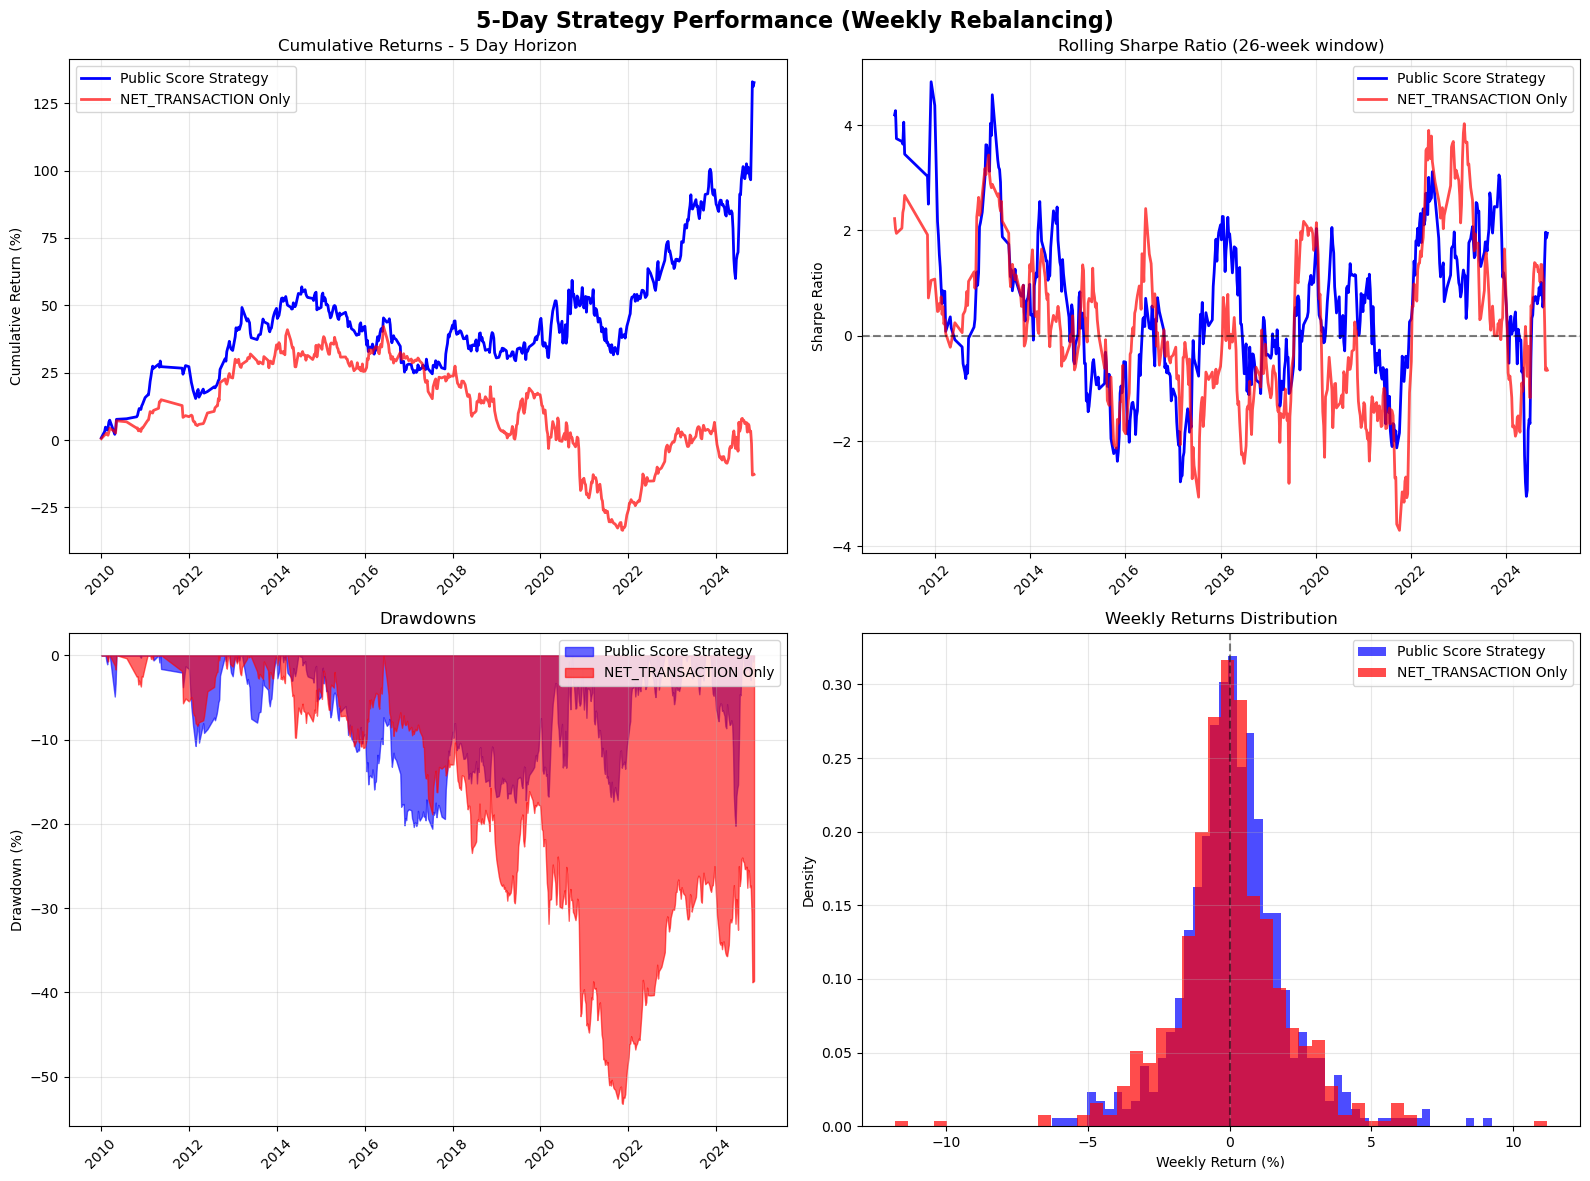


📊 Plotting 21-Day Strategies (Monthly Rebalancing)


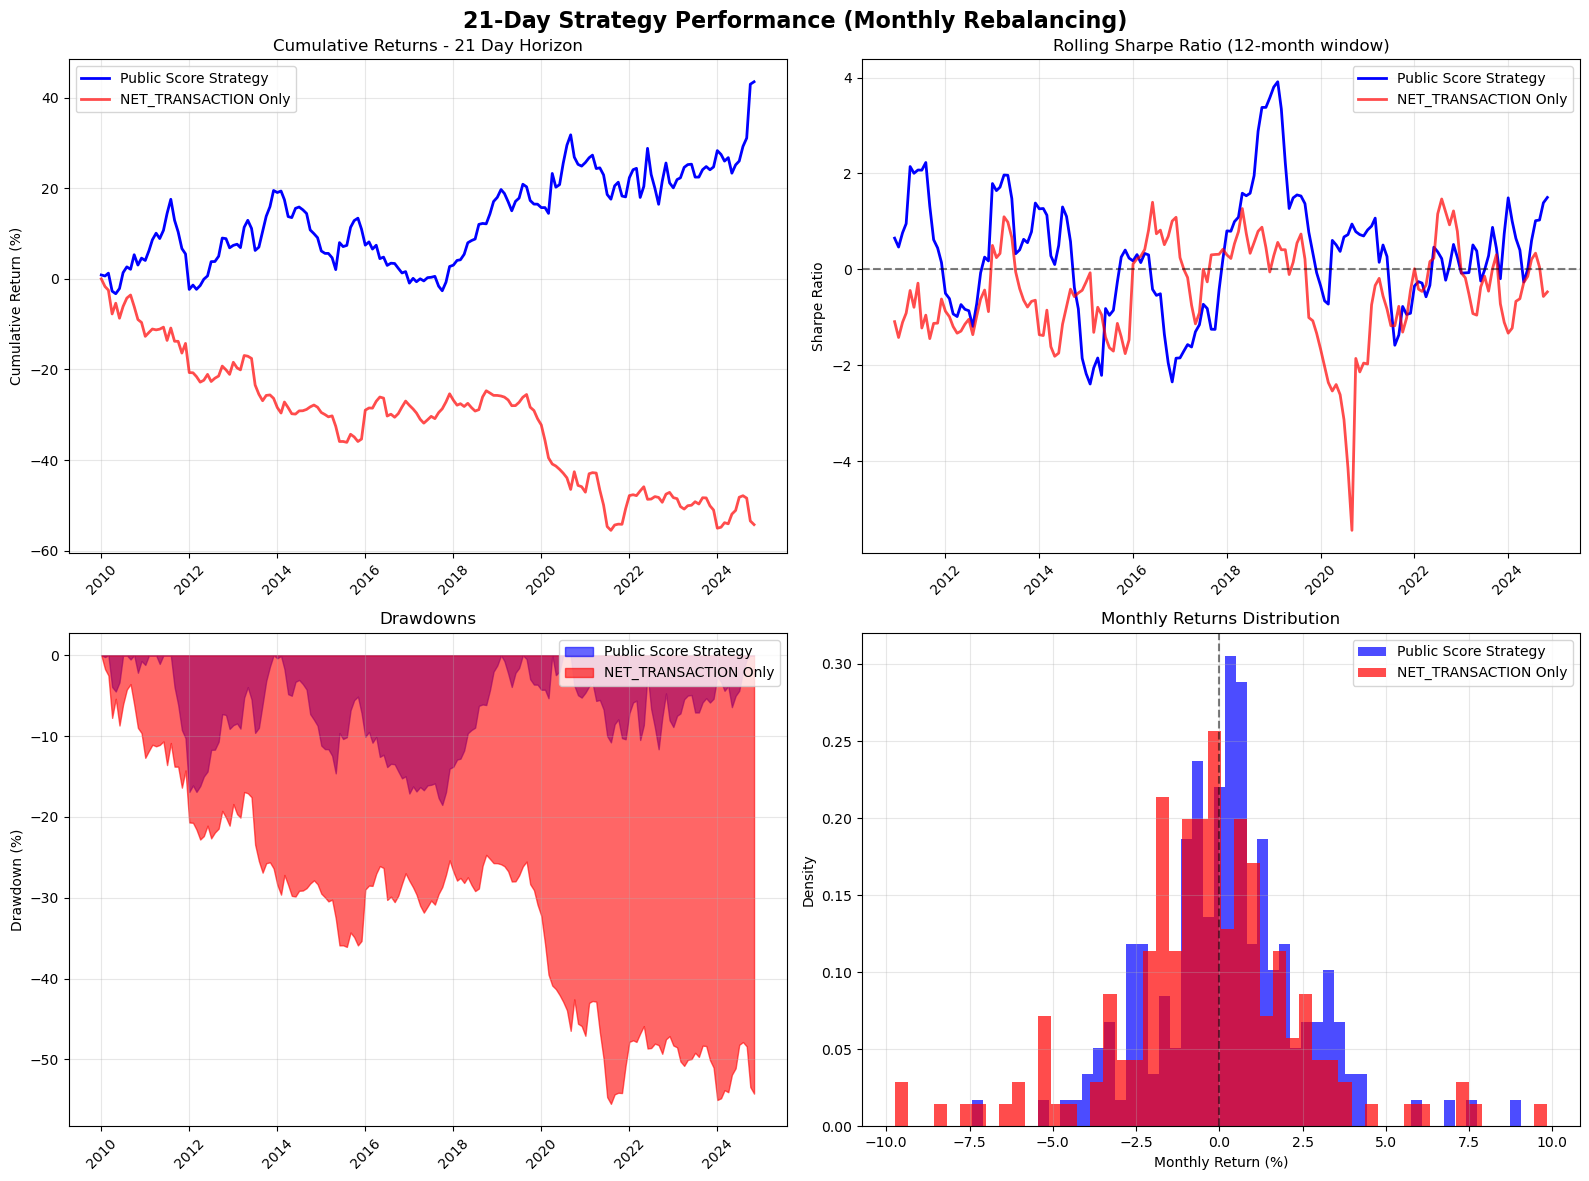


REBALANCING EFFICIENCY ANALYSIS

REBALANCING ANALYSIS: Public Score Strategy

📊 PORTFOLIO SIZE ANALYSIS:
Weekly Rebalancing:
  • Average long positions: 11.2 stocks
  • Average short positions: 11.2 stocks
  • Total average positions: 22.4 stocks

Monthly Rebalancing:
  • Average long positions: 40.9 stocks
  • Average short positions: 40.9 stocks
  • Total average positions: 81.8 stocks

💰 ANNUAL COST ANALYSIS (10bps per trade):
Weekly Rebalancing: 116.37% per year
Monthly Rebalancing: 98.13% per year
Cost Savings: 18.24%

REBALANCING ANALYSIS: NET_TRANSACTION Only

📊 PORTFOLIO SIZE ANALYSIS:
Weekly Rebalancing:
  • Average long positions: 11.2 stocks
  • Average short positions: 11.2 stocks
  • Total average positions: 22.4 stocks

Monthly Rebalancing:
  • Average long positions: 40.9 stocks
  • Average short positions: 40.9 stocks
  • Total average positions: 81.8 stocks

💰 ANNUAL COST ANALYSIS (10bps per trade):
Weekly Rebalancing: 116.37% per year
Monthly Rebalancing: 98.13% per 

In [2]:
# ============================================================================
# CONFIGURATION & DATA LOADING
# ============================================================================

# Constants
FEATURES = ['NET_TRANSACTION', 'excess_return_30d', 'volume_zscore_30d', 
            'Level_1_count', 'Level_2_count', 'Level_3_count']
TOP_PCT = 0.2
COST_BPS = 10

def load_and_prepare_data(file_path):
    """Load and prepare the base dataset"""
    df = pd.read_csv(file_path)
    df['FILING_DATE'] = pd.to_datetime(df['FILING_DATE'])
    df['week'] = df['FILING_DATE'].dt.to_period('W').dt.start_time
    df['month'] = df['FILING_DATE'].dt.to_period('M').dt.start_time
    df = df[df['FILING_DATE'] >= '2006-01-01'].copy()
    return df

# ============================================================================
# CORE STRATEGY FUNCTIONS
# ============================================================================

def calculate_z_scores(train_data, test_data, features):
    """Calculate z-scores for features using market-wide statistics"""
    market_means = train_data[features].mean()
    market_stds = train_data[features].std()
    
    for col in features:
        test_data[f'z_{col}'] = (test_data[col] - market_means[col]) / market_stds[col]
    
    return test_data

def create_portfolio(data, score_col, top_pct=0.2, min_stocks=5):
    """Create equal-weighted long-short portfolio"""
    if len(data) < min_stocks:
        return None
    
    # Remove extreme outliers
    q_low = data[score_col].quantile(0.01)
    q_high = data[score_col].quantile(0.99)
    filtered_data = data[(data[score_col] >= q_low) & (data[score_col] <= q_high)]
    
    if len(filtered_data) < min_stocks:
        filtered_data = data
    
    sorted_data = filtered_data.sort_values(score_col, ascending=False)
    n_stocks = max(1, int(len(sorted_data) * top_pct))
    
    if len(sorted_data) < 2 * n_stocks:
        n_stocks = max(1, len(sorted_data) // 2)
    
    long_portfolio = sorted_data.head(n_stocks)
    short_portfolio = sorted_data.tail(n_stocks)
    
    return {
        'long_5d': long_portfolio['relative_return_r_to_r5'].mean(),
        'short_5d': short_portfolio['relative_return_r_to_r5'].mean(),
        'long_short_5d': long_portfolio['relative_return_r_to_r5'].mean() - short_portfolio['relative_return_r_to_r5'].mean(),
        'long_21d': long_portfolio['relative_return_r_to_r21'].mean(),
        'short_21d': short_portfolio['relative_return_r_to_r21'].mean(),
        'long_short_21d': long_portfolio['relative_return_r_to_r21'].mean() - short_portfolio['relative_return_r_to_r21'].mean(),
        'n_long': n_stocks,
        'n_short': n_stocks,
        'long_stocks': long_portfolio['ISSUERTRADINGSYMBOL'].tolist(),
        'short_stocks': short_portfolio['ISSUERTRADINGSYMBOL'].tolist()
    }

def run_weekly_strategy_backtest(df, weeks, strategy_type="public_score"):
    """Run backtest with WEEKLY rebalancing (for 5-day returns)"""
    weekly_returns = []
    
    for current_week in tqdm(weeks, desc=f"Weekly Rebalancing - {strategy_type}"):
        train_start = current_week - pd.Timedelta(weeks=52)
        train_data = df[(df['week'] >= train_start) & (df['week'] < current_week)]
        
        if train_data.empty:
            continue

        test_data = df[df['week'] == current_week].copy()
        trade_data = test_data.dropna(subset=['relative_return_r_to_r5', 'relative_return_r_to_r21'])
        
        if len(trade_data) < 30:
            continue

        if strategy_type == "public_score":
            test_data = calculate_z_scores(train_data, test_data, FEATURES)
            test_data['public_score'] = (
                test_data['z_NET_TRANSACTION'] +
                0.5*test_data['z_Level_1_count'] + 0.3*test_data['z_Level_2_count'] + 0.2*test_data['z_Level_3_count']
            )
            portfolio_result = create_portfolio(test_data, 'public_score', TOP_PCT)
            
        elif strategy_type == "net_transaction":
            market_mean = train_data['NET_TRANSACTION'].mean()
            market_std = train_data['NET_TRANSACTION'].std()
            trade_data['net_txn_z'] = (trade_data['NET_TRANSACTION'] - market_mean) / market_std if market_std > 0 else 0
            portfolio_result = create_portfolio(trade_data, 'net_txn_z', TOP_PCT)

        if portfolio_result is not None:
            weekly_returns.append({
                'period': current_week,
                'rebalancing_freq': 'weekly',
                **portfolio_result
            })
    
    return pd.DataFrame(weekly_returns)

def run_monthly_strategy_backtest(df, months, strategy_type="public_score"):
    """Run backtest with MONTHLY rebalancing (for 21-day returns)"""
    monthly_returns = []
    
    for current_month in tqdm(months, desc=f"Monthly Rebalancing - {strategy_type}"):
        train_start = current_month - pd.DateOffset(months=12)
        train_data = df[(df['month'] >= train_start) & (df['month'] < current_month)]
        
        if train_data.empty:
            continue

        test_data = df[df['month'] == current_month].copy()
        trade_data = test_data.dropna(subset=['relative_return_r_to_r5', 'relative_return_r_to_r21'])
        
        if len(trade_data) < 30:
            continue

        if strategy_type == "public_score":
            test_data = calculate_z_scores(train_data, test_data, FEATURES)
            test_data['public_score'] = (
                test_data['z_NET_TRANSACTION'] +
                0.5*test_data['z_Level_1_count'] + 0.3*test_data['z_Level_2_count'] + 0.2*test_data['z_Level_3_count']
            )
            portfolio_result = create_portfolio(test_data, 'public_score', TOP_PCT)
            
        elif strategy_type == "net_transaction":
            market_mean = train_data['NET_TRANSACTION'].mean()
            market_std = train_data['NET_TRANSACTION'].std()
            trade_data['net_txn_z'] = (trade_data['NET_TRANSACTION'] - market_mean) / market_std if market_std > 0 else 0
            portfolio_result = create_portfolio(trade_data, 'net_txn_z', TOP_PCT)

        if portfolio_result is not None:
            monthly_returns.append({
                'period': current_month,
                'rebalancing_freq': 'monthly',
                **portfolio_result
            })
    
    return pd.DataFrame(monthly_returns)

# ============================================================================
# PERFORMANCE ANALYSIS FUNCTIONS
# ============================================================================

def calculate_performance_stats(returns_series, periods_per_year=52):
    """Calculate comprehensive performance statistics"""
    if len(returns_series) == 0:
        return None
        
    excess_returns = returns_series  # Assuming returns are already excess returns
    
    # Basic metrics
    mean_return = returns_series.mean()
    std_dev = returns_series.std()
    sharpe_ratio = (excess_returns.mean() / excess_returns.std()) * np.sqrt(periods_per_year) if excess_returns.std() > 0 else 0
    
    # Statistical significance
    t_stat, p_value = stats.ttest_1samp(returns_series, 0)
    
    # Additional metrics
    win_rate = (returns_series > 0).mean()
    
    # Drawdown analysis
    cumulative_returns = (1 + returns_series).cumprod()
    running_max = cumulative_returns.expanding().max()
    drawdowns = (cumulative_returns - running_max) / running_max
    max_drawdown = drawdowns.min()
    
    return {
        'mean_return': mean_return,
        'std_dev': std_dev,
        'sharpe_ratio': sharpe_ratio,
        't_statistic': t_stat,
        'p_value': p_value,
        'win_rate': win_rate,
        'max_drawdown': max_drawdown,
        'annualized_return': mean_return * periods_per_year,
        'total_periods': len(returns_series),
        'positive_periods': (returns_series > 0).sum()
    }

def apply_transaction_costs(returns_series, cost_bps=10, rebalancing_freq='weekly'):
    """Apply transaction costs to returns based on rebalancing frequency"""
    if rebalancing_freq == 'weekly':
        cost_per_period = cost_bps / 10000
    else:  # monthly
        cost_per_period = cost_bps / 10000  # Same cost per rebalance, but fewer rebalances
    
    return returns_series - cost_per_period

# ============================================================================
# VISUALIZATION FUNCTIONS - SEPARATE FOR 5-DAY AND 21-DAY
# ============================================================================

def plot_5day_strategy_comparison(weekly_public, weekly_net):
    """Create comprehensive plots for 5-day strategies (weekly rebalancing)"""
    
    # Ensure both dataframes have the same periods and are sorted
    common_periods = sorted(set(weekly_public['period']).intersection(set(weekly_net['period'])))
    weekly_public = weekly_public[weekly_public['period'].isin(common_periods)].sort_values('period')
    weekly_net = weekly_net[weekly_net['period'].isin(common_periods)].sort_values('period')
    
    # Create the plots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('5-Day Strategy Performance (Weekly Rebalancing)', fontsize=16, fontweight='bold')
    
    # Plot 1: Cumulative Returns
    cumulative_public = (1 + weekly_public['long_short_5d']).cumprod() - 1
    cumulative_net = (1 + weekly_net['long_short_5d']).cumprod() - 1
    
    axes[0, 0].plot(weekly_public['period'], cumulative_public * 100, 
                   label='Public Score Strategy', linewidth=2, color='blue')
    axes[0, 0].plot(weekly_net['period'], cumulative_net * 100, 
                   label='NET_TRANSACTION Only', linewidth=2, color='red', alpha=0.7)
    axes[0, 0].set_title('Cumulative Returns - 5 Day Horizon')
    axes[0, 0].set_ylabel('Cumulative Return (%)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Plot 2: Rolling Sharpe Ratio (26-week window)
    window = 26
    rolling_sharpe_public = (weekly_public['long_short_5d'].rolling(window).mean() / 
                            weekly_public['long_short_5d'].rolling(window).std()) * np.sqrt(52)
    rolling_sharpe_net = (weekly_net['long_short_5d'].rolling(window).mean() / 
                         weekly_net['long_short_5d'].rolling(window).std()) * np.sqrt(52)
    
    axes[0, 1].plot(weekly_public['period'], rolling_sharpe_public, 
                   label='Public Score Strategy', linewidth=2, color='blue')
    axes[0, 1].plot(weekly_net['period'], rolling_sharpe_net, 
                   label='NET_TRANSACTION Only', linewidth=2, color='red', alpha=0.7)
    axes[0, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[0, 1].set_title(f'Rolling Sharpe Ratio ({window}-week window)')
    axes[0, 1].set_ylabel('Sharpe Ratio')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # Plot 3: Drawdowns
    def calculate_drawdowns(cumulative_returns):
        running_max = cumulative_returns.expanding().max()
        drawdown = (cumulative_returns - running_max) / running_max
        return drawdown
    
    drawdown_public = calculate_drawdowns(1 + cumulative_public)
    drawdown_net = calculate_drawdowns(1 + cumulative_net)
    
    axes[1, 0].fill_between(weekly_public['period'], drawdown_public * 100, 0, 
                           alpha=0.6, color='blue', label='Public Score Strategy')
    axes[1, 0].fill_between(weekly_net['period'], drawdown_net * 100, 0, 
                           alpha=0.6, color='red', label='NET_TRANSACTION Only')
    axes[1, 0].set_title('Drawdowns')
    axes[1, 0].set_ylabel('Drawdown (%)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # Plot 4: Weekly Returns Distribution
    axes[1, 1].hist(weekly_public['long_short_5d'] * 100, bins=50, alpha=0.7, 
                   label='Public Score Strategy', color='blue', density=True)
    axes[1, 1].hist(weekly_net['long_short_5d'] * 100, bins=50, alpha=0.7, 
                   label='NET_TRANSACTION Only', color='red', density=True)
    axes[1, 1].axvline(x=0, color='black', linestyle='--', alpha=0.5)
    axes[1, 1].set_title('Weekly Returns Distribution')
    axes[1, 1].set_xlabel('Weekly Return (%)')
    axes[1, 1].set_ylabel('Density')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'common_periods': common_periods,
        'cumulative_public': cumulative_public,
        'cumulative_net': cumulative_net
    }

def plot_21day_strategy_comparison(monthly_public, monthly_net):
    """Create comprehensive plots for 21-day strategies (monthly rebalancing)"""
    
    # Ensure both dataframes have the same periods and are sorted
    common_periods = sorted(set(monthly_public['period']).intersection(set(monthly_net['period'])))
    monthly_public = monthly_public[monthly_public['period'].isin(common_periods)].sort_values('period')
    monthly_net = monthly_net[monthly_net['period'].isin(common_periods)].sort_values('period')
    
    # Create the plots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('21-Day Strategy Performance (Monthly Rebalancing)', fontsize=16, fontweight='bold')
    
    # Plot 1: Cumulative Returns
    cumulative_public = (1 + monthly_public['long_short_21d']).cumprod() - 1
    cumulative_net = (1 + monthly_net['long_short_21d']).cumprod() - 1
    
    axes[0, 0].plot(monthly_public['period'], cumulative_public * 100, 
                   label='Public Score Strategy', linewidth=2, color='blue')
    axes[0, 0].plot(monthly_net['period'], cumulative_net * 100, 
                   label='NET_TRANSACTION Only', linewidth=2, color='red', alpha=0.7)
    axes[0, 0].set_title('Cumulative Returns - 21 Day Horizon')
    axes[0, 0].set_ylabel('Cumulative Return (%)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Plot 2: Rolling Sharpe Ratio (12-month window)
    window = 12
    rolling_sharpe_public = (monthly_public['long_short_21d'].rolling(window).mean() / 
                            monthly_public['long_short_21d'].rolling(window).std()) * np.sqrt(12)
    rolling_sharpe_net = (monthly_net['long_short_21d'].rolling(window).mean() / 
                         monthly_net['long_short_21d'].rolling(window).std()) * np.sqrt(12)
    
    axes[0, 1].plot(monthly_public['period'], rolling_sharpe_public, 
                   label='Public Score Strategy', linewidth=2, color='blue')
    axes[0, 1].plot(monthly_net['period'], rolling_sharpe_net, 
                   label='NET_TRANSACTION Only', linewidth=2, color='red', alpha=0.7)
    axes[0, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[0, 1].set_title(f'Rolling Sharpe Ratio ({window}-month window)')
    axes[0, 1].set_ylabel('Sharpe Ratio')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # Plot 3: Drawdowns
    def calculate_drawdowns(cumulative_returns):
        running_max = cumulative_returns.expanding().max()
        drawdown = (cumulative_returns - running_max) / running_max
        return drawdown
    
    drawdown_public = calculate_drawdowns(1 + cumulative_public)
    drawdown_net = calculate_drawdowns(1 + cumulative_net)
    
    axes[1, 0].fill_between(monthly_public['period'], drawdown_public * 100, 0, 
                           alpha=0.6, color='blue', label='Public Score Strategy')
    axes[1, 0].fill_between(monthly_net['period'], drawdown_net * 100, 0, 
                           alpha=0.6, color='red', label='NET_TRANSACTION Only')
    axes[1, 0].set_title('Drawdowns')
    axes[1, 0].set_ylabel('Drawdown (%)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # Plot 4: Monthly Returns Distribution
    axes[1, 1].hist(monthly_public['long_short_21d'] * 100, bins=50, alpha=0.7, 
                   label='Public Score Strategy', color='blue', density=True)
    axes[1, 1].hist(monthly_net['long_short_21d'] * 100, bins=50, alpha=0.7, 
                   label='NET_TRANSACTION Only', color='red', density=True)
    axes[1, 1].axvline(x=0, color='black', linestyle='--', alpha=0.5)
    axes[1, 1].set_title('Monthly Returns Distribution')
    axes[1, 1].set_xlabel('Monthly Return (%)')
    axes[1, 1].set_ylabel('Density')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'common_periods': common_periods,
        'cumulative_public': cumulative_public,
        'cumulative_net': cumulative_net
    }

def analyze_strategy_performance_separate(returns_df, strategy_name, rebalancing_freq='weekly'):
    """Comprehensive performance analysis with proper period alignment"""
    print(f"\n{'='*60}")
    print(f"STRATEGY: {strategy_name} ({rebalancing_freq.upper()} Rebalancing)")
    print(f"{'='*60}")
    
    if rebalancing_freq == 'weekly':
        return_col = 'long_short_5d'
        periods_per_year = 52
        period_name = 'Weekly'
    else:  # monthly
        return_col = 'long_short_21d'
        periods_per_year = 12
        period_name = 'Monthly'
    
    returns = returns_df[return_col].dropna()
    
    if len(returns) == 0:
        print("No returns data available")
        return None
        
    stats_before = calculate_performance_stats(returns, periods_per_year)
    stats_after = calculate_performance_stats(apply_transaction_costs(returns, COST_BPS, rebalancing_freq), periods_per_year)
    
    print(f"\n{period_name.upper()} RETURNS ANALYSIS:")
    print(f"Before Costs:")
    print(f"  • Annual Return: {stats_before['annualized_return']*100:7.2f}%")
    print(f"  • Sharpe Ratio:  {stats_before['sharpe_ratio']:6.3f}")
    print(f"  • Win Rate:      {stats_before['win_rate']*100:5.1f}%")
    print(f"  • T-Statistic:   {stats_before['t_statistic']:6.3f}")
    print(f"  • P-Value:       {stats_before['p_value']:6.4f}")
    print(f"  • Max Drawdown:  {stats_before['max_drawdown']*100:5.1f}%")
    
    print(f"\nAfter {COST_BPS}bps Costs:")
    print(f"  • Annual Return: {stats_after['annualized_return']*100:7.2f}%")
    print(f"  • Sharpe Ratio:  {stats_after['sharpe_ratio']:6.3f}")
    
    return {
        'stats_before': stats_before,
        'stats_after': stats_after,
        'rebalancing_freq': rebalancing_freq
    }

def analyze_rebalancing_separate(weekly_returns, monthly_returns, strategy_name):
    """Analyze portfolio turnover for both rebalancing frequencies"""
    print(f"\n{'='*60}")
    print(f"REBALANCING ANALYSIS: {strategy_name}")
    print(f"{'='*60}")
    
    # Weekly rebalancing analysis
    weekly_avg_long = weekly_returns['n_long'].mean()
    weekly_avg_short = weekly_returns['n_short'].mean()
    weekly_total_positions = weekly_avg_long + weekly_avg_short
    
    # Monthly rebalancing analysis
    monthly_avg_long = monthly_returns['n_long'].mean()
    monthly_avg_short = monthly_returns['n_short'].mean()
    monthly_total_positions = monthly_avg_long + monthly_avg_short
    
    print(f"\n PORTFOLIO SIZE ANALYSIS:")
    print(f"Weekly Rebalancing:")
    print(f"  • Average long positions: {weekly_avg_long:.1f} stocks")
    print(f"  • Average short positions: {weekly_avg_short:.1f} stocks")
    print(f"  • Total average positions: {weekly_total_positions:.1f} stocks")
    
    print(f"\nMonthly Rebalancing:")
    print(f"  • Average long positions: {monthly_avg_long:.1f} stocks")
    print(f"  • Average short positions: {monthly_avg_short:.1f} stocks")
    print(f"  • Total average positions: {monthly_total_positions:.1f} stocks")
    
    # Cost analysis
    print(f"\n ANNUAL COST ANALYSIS ({COST_BPS}bps per trade):")
    annual_cost_weekly = weekly_total_positions * (COST_BPS / 10000) * 52
    annual_cost_monthly = monthly_total_positions * (COST_BPS / 10000) * 12
    
    print(f"Weekly Rebalancing: {annual_cost_weekly*100:.2f}% per year")
    print(f"Monthly Rebalancing: {annual_cost_monthly*100:.2f}% per year")
    print(f"Cost Savings: {(annual_cost_weekly - annual_cost_monthly)*100:.2f}%")
    
    return {
        'weekly_avg_positions': weekly_total_positions,
        'monthly_avg_positions': monthly_total_positions,
        'annual_cost_weekly': annual_cost_weekly,
        'annual_cost_monthly': annual_cost_monthly
    }

# ============================================================================
# MAIN EXECUTION
# ============================================================================

def main():
    # Load data
    df = load_and_prepare_data("Insider_Trading_Features.csv")
    
    # Get rebalancing points
    weeks = sorted(df[df['FILING_DATE'].dt.year >= 2010]['week'].unique())
    months = sorted(df[df['FILING_DATE'].dt.year >= 2010]['month'].unique())
    
    print("="*80)
    print("RUNNING 5-DAY STRATEGIES (WEEKLY REBALANCING)")
    print("="*80)
    
    # Weekly rebalancing strategies (5-day focus)
    weekly_public = run_weekly_strategy_backtest(df, weeks, "public_score")

    weekly_net = run_weekly_strategy_backtest(df, weeks, "net_transaction")
    
    print("\n" + "="*80)
    print("RUNNING 21-DAY STRATEGIES (MONTHLY REBALANCING)")
    print("="*80)
    
    # Monthly rebalancing strategies (21-day focus)
    monthly_public = run_monthly_strategy_backtest(df, months, "public_score")
    monthly_net = run_monthly_strategy_backtest(df, months, "net_transaction")
    
    # Performance analysis
    print("\n" + "="*80)
    print("PERFORMANCE ANALYSIS")
    print("="*80)
    
    # 5-day strategies analysis
    print("\n 5-DAY STRATEGIES ANALYSIS (Weekly Rebalancing)")
    weekly_public_perf = analyze_strategy_performance_separate(weekly_public, "Public Score Strategy", 'weekly')
    weekly_net_perf = analyze_strategy_performance_separate(weekly_net, "NET_TRANSACTION Only", 'weekly')
    
    # 21-day strategies analysis
    print("\n 21-DAY STRATEGIES ANALYSIS (Monthly Rebalancing)")
    monthly_public_perf = analyze_strategy_performance_separate(monthly_public, "Public Score Strategy", 'monthly')
    monthly_net_perf = analyze_strategy_performance_separate(monthly_net, "NET_TRANSACTION Only", 'monthly')
    
    # Visualization
    print("\n" + "="*80)
    print("VISUALIZATION")
    print("="*80)
    
    # Plot 5-day strategies
    print("\n Plotting 5-Day Strategies (Weekly Rebalancing)")
    plot_5day_data = plot_5day_strategy_comparison(weekly_public, weekly_net)
    
    # Plot 21-day strategies
    print("\n Plotting 21-Day Strategies (Monthly Rebalancing)")
    plot_21day_data = plot_21day_strategy_comparison(monthly_public, monthly_net)
    
    # Rebalancing analysis
    print("\n" + "="*80)
    print("REBALANCING EFFICIENCY ANALYSIS")
    print("="*80)
    
    public_rebalancing = analyze_rebalancing_separate(weekly_public, monthly_public, "Public Score Strategy")
    net_rebalancing = analyze_rebalancing_separate(weekly_net, monthly_net, "NET_TRANSACTION Only")
    
    return {
        'weekly_public': weekly_public,
        'weekly_net': weekly_net,
        'monthly_public': monthly_public,
        'monthly_net': monthly_net,
        'weekly_performance': {
            'public': weekly_public_perf,
            'net': weekly_net_perf
        },
        'monthly_performance': {
            'public': monthly_public_perf,
            'net': monthly_net_perf
        },
        'rebalancing_analysis': {
            'public': public_rebalancing,
            'net': net_rebalancing
        }
    }

if __name__ == "__main__":
    results = main()

#### Weekly Final Strategy

In [4]:
# downloading stock price data
final_data = pd.read_csv('Insider_Trading_Features.csv')
final_data['FILING_DATE'] = pd.to_datetime(final_data['FILING_DATE'])
price_cache = {}
for ticker in final_data['ISSUERTRADINGSYMBOL'].unique():
    df = yf.download(ticker, start="2000-01-01", end="2025-12-12", progress=False)
    if not df.empty:
        df = df[['Close']].reset_index()
        price_cache[ticker] = df
df = yf.download("^GSPC", start="2000-01-01", end="2025-12-12", progress=False)
if not df.empty:
    df = df[['Close']].reset_index()
    price_cache["^GSPC"] = df

In [11]:
len(price_cache.keys())

604

In [6]:
final_data.columns

Index(['FILING_DATE', 'ISSUERTRADINGSYMBOL', 'TRANS_SHARES_SIGN',
       'price_report', 'Days_Diff', 'return_t_to_t5', 'return_t_to_t21',
       'return_r_to_r5', 'return_r_to_r21', 'relative_return_t_to_t5',
       'relative_return_r_to_r5', 'relative_return_t_to_t21',
       'relative_return_r_to_r21', 'Level_1_count', 'Level_2_count',
       'Level_3_count', 'NET_TRANSACTION', 'excess_return_7d',
       'excess_return_30d', 'volume_zscore_30d', 'volume_zscore_7d'],
      dtype='object')

Loading and preparing data...
Running weekly backtests...


Weekly - public_score: 100%|██████████| 776/776 [03:38<00:00,  3.55it/s]


  public_score: 775 periods


Weekly - net_transaction: 100%|██████████| 776/776 [03:22<00:00,  3.84it/s]


  net_transaction: 775 periods
Running monthly backtests...


Monthly - public_score: 100%|██████████| 179/179 [03:40<00:00,  1.23s/it]


  public_score: 179 periods


Monthly - net_transaction: 100%|██████████| 179/179 [04:23<00:00,  1.47s/it]


  net_transaction: 179 periods

PERFORMANCE ANALYSIS

STRATEGY: public_score (WEEKLY Rebalancing)

📈 PERFORMANCE STATS BEFORE COSTS:
  Annual Return: -2.35%
  Sharpe Ratio:  -0.144
  T-Statistic:   -0.556
  P-Value:       0.5785
  Win Rate:      48.0%
  Max Drawdown:  -64.7%
  Total Periods: 775
  Positive:      372

💰 PERFORMANCE STATS AFTER 10bps COSTS:
  Annual Return: -7.55%
  Sharpe Ratio:  -0.463

STRATEGY: net_transaction (WEEKLY Rebalancing)

📈 PERFORMANCE STATS BEFORE COSTS:
  Annual Return: -8.02%
  Sharpe Ratio:  -0.506
  T-Statistic:   -1.953
  P-Value:       0.0511
  Win Rate:      46.1%
  Max Drawdown:  -82.3%
  Total Periods: 775
  Positive:      357

💰 PERFORMANCE STATS AFTER 10bps COSTS:
  Annual Return: -13.22%
  Sharpe Ratio:  -0.834

STRATEGY: public_score (MONTHLY Rebalancing)

📈 PERFORMANCE STATS BEFORE COSTS:
  Annual Return: 2.72%
  Sharpe Ratio:  0.275
  T-Statistic:   1.062
  P-Value:       0.2895
  Win Rate:      50.3%
  Max Drawdown:  -14.5%
  Total Periods:

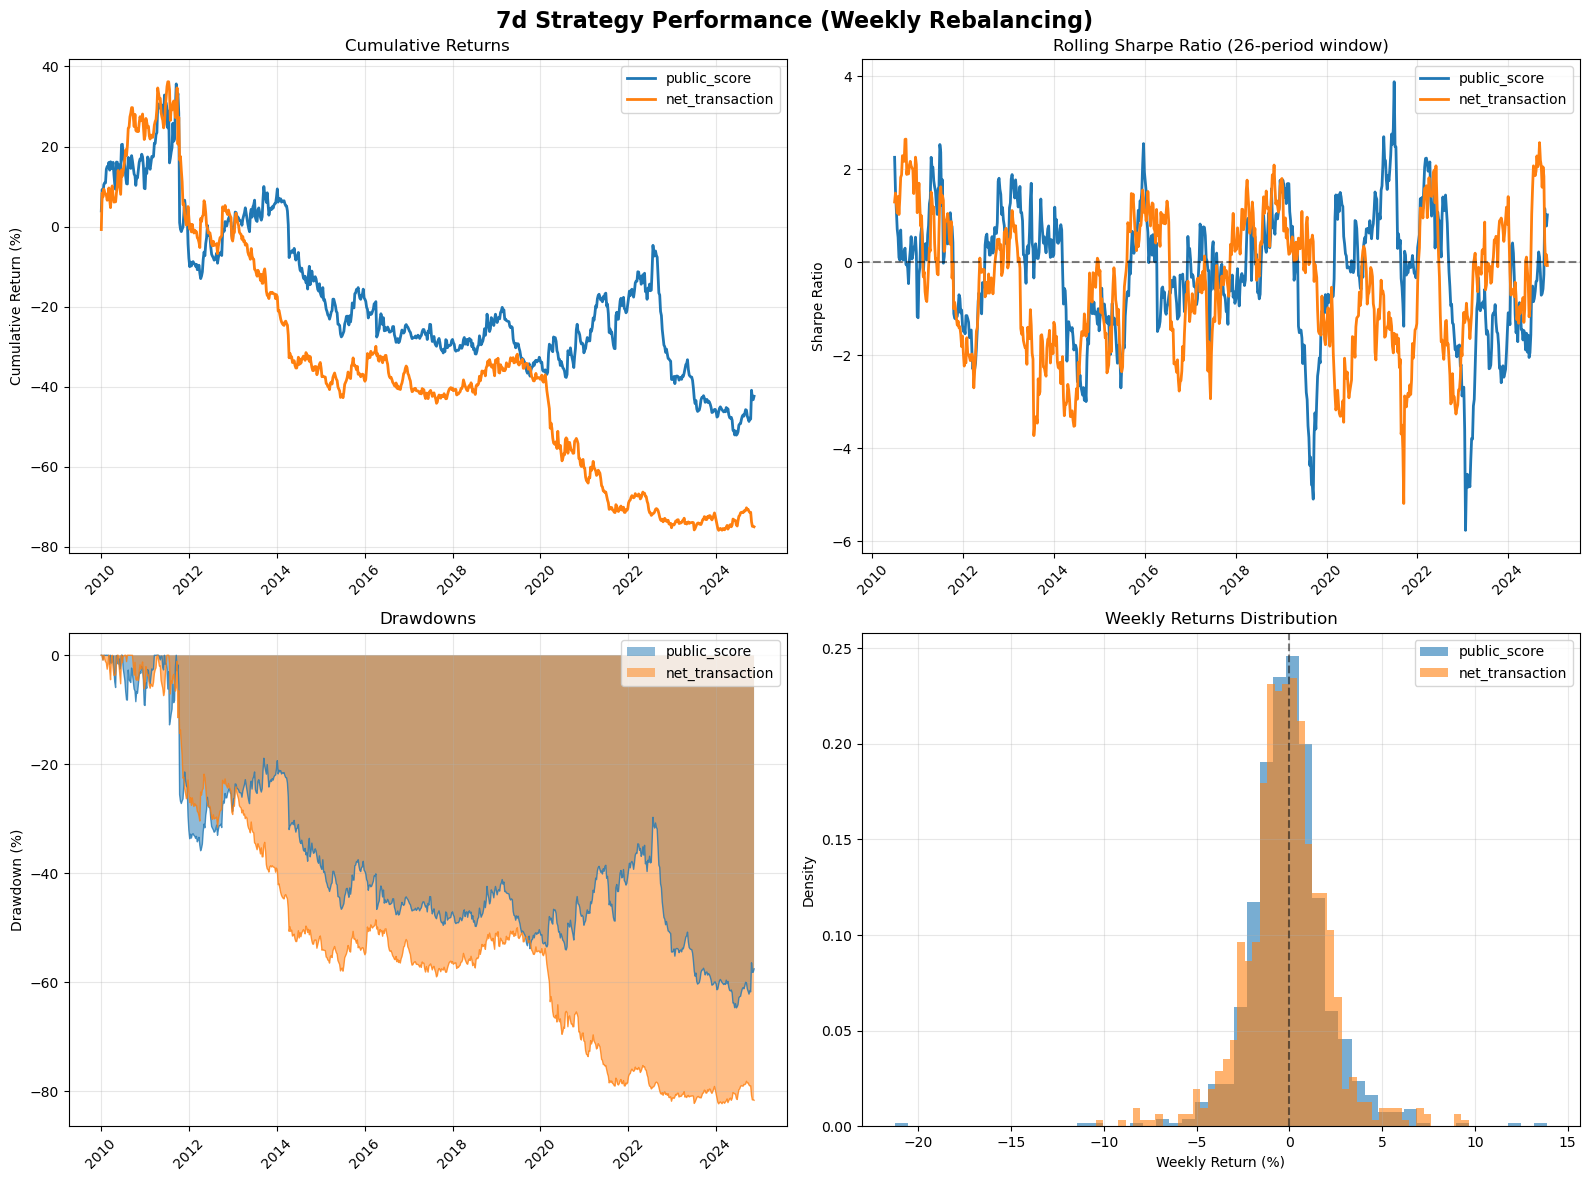

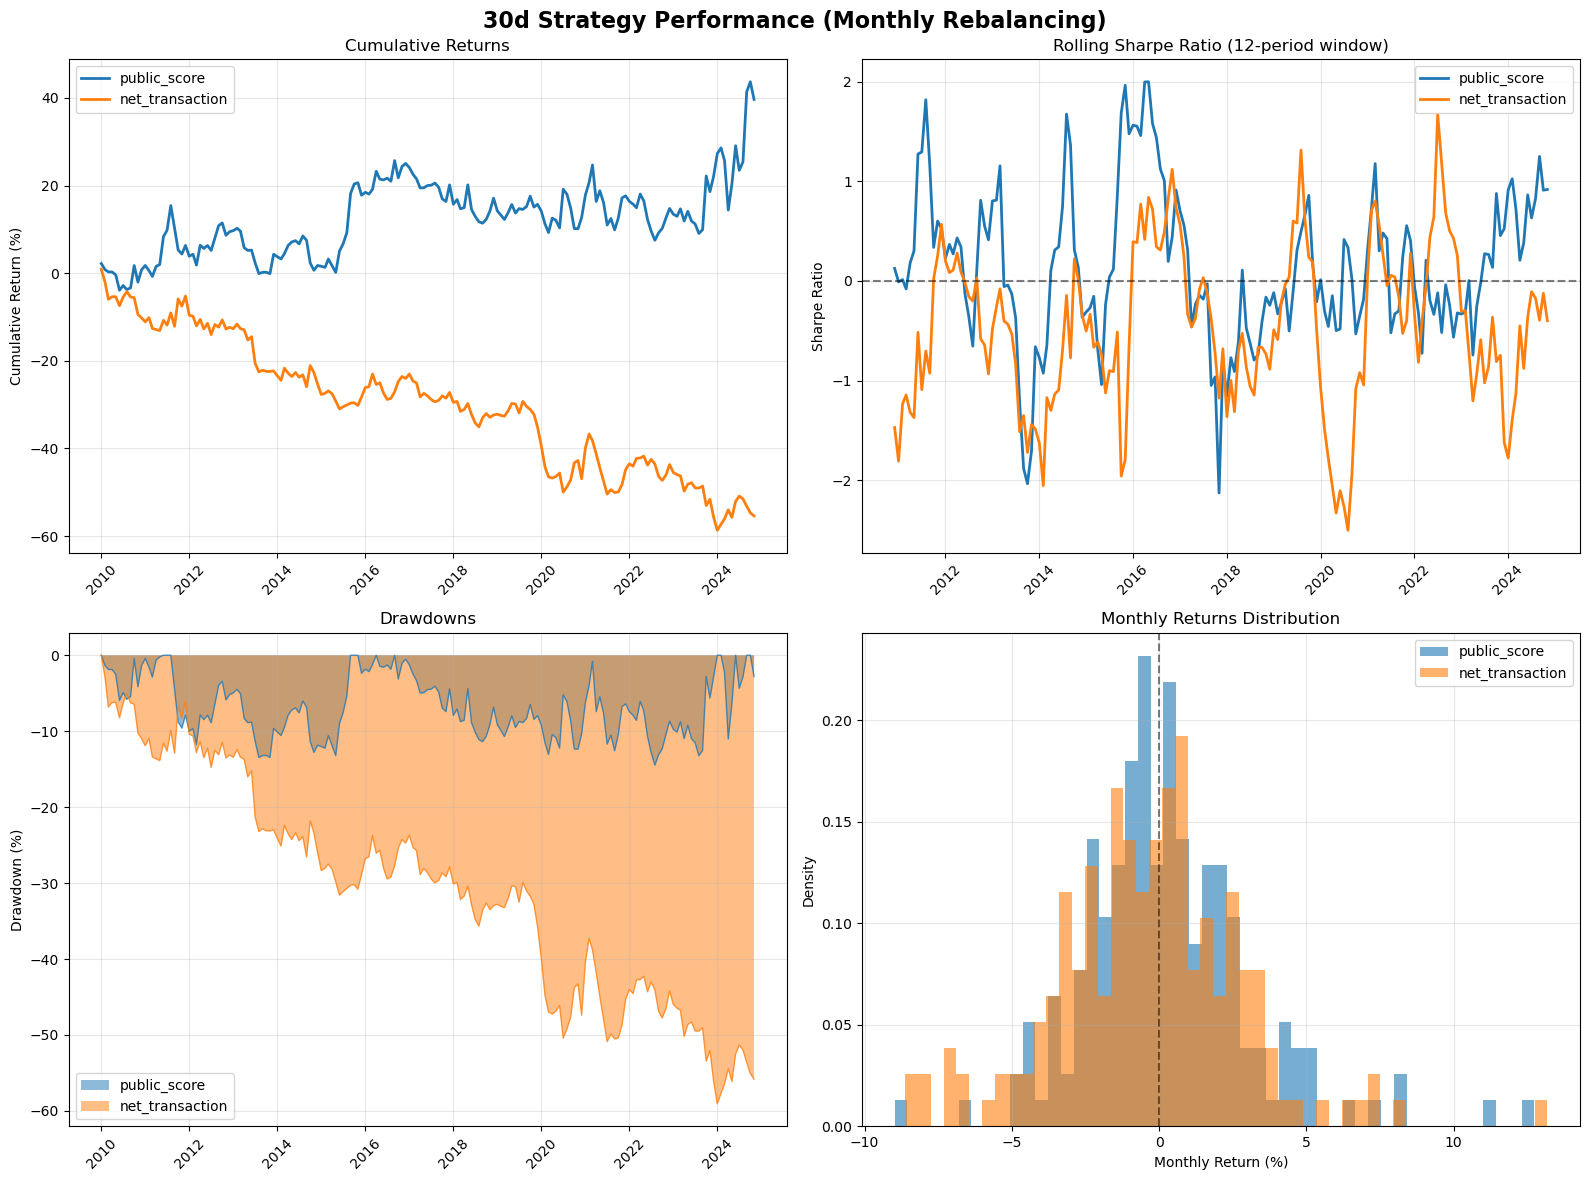


REBALANCING ANALYSIS: public_score
Weekly avg long: 8.9, short: 8.9
Monthly avg long: 40.9, short: 40.9
Annualized Weekly Return: -2.35%
Annualized Monthly Return: 2.72%

REBALANCING ANALYSIS: net_transaction
Weekly avg long: 8.9, short: 8.9
Monthly avg long: 40.9, short: 40.9
Annualized Weekly Return: -8.02%
Annualized Monthly Return: -4.79%


In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
from tqdm import tqdm
import matplotlib.pyplot as plt

# ============================================================================
# CONFIGURATION & DATA LOADING
# ============================================================================

FEATURES = [
    'NET_TRANSACTION',
    'excess_return_30d',
    'volume_zscore_30d',
    'Level_1_count',
    'Level_2_count',
    'Level_3_count'
]

TOP_PCT = 0.2
COST_BPS = 10  # per rebalance
MIN_BULK_WEEK = 5
MIN_BULK_MONTH = 5
MIN_STOCKS = 5

def load_and_prepare_data(file_path):
    """Load and prepare the base dataset."""
    df = pd.read_csv(file_path)
    df['FILING_DATE'] = pd.to_datetime(df['FILING_DATE'])
    df['week'] = df['FILING_DATE'].dt.to_period('W').dt.start_time
    df['month'] = df['FILING_DATE'].dt.to_period('M').dt.start_time
    df = df[(df['FILING_DATE'] >= '2006-01-01') & (df['FILING_DATE'] <= '2025-01-01')].copy()
    
    # Ensure ticker column exists
    if 'ISSUERTRADINGSYMBOL' not in df.columns and 'TICKER' in df.columns:
        df['ISSUERTRADINGSYMBOL'] = df['TICKER']
        
    return df

# ============================================================================
# DATE HELPERS
# ============================================================================

def get_next_monday(date):
    """Return the next Monday after the given date."""
    date = pd.Timestamp(date).normalize()
    days_ahead = (0 - date.weekday()) % 7
    if days_ahead == 0:  # If it's already Monday, go to next week
        days_ahead = 7
    return date + pd.Timedelta(days=days_ahead)

def get_first_trading_day_next_month(date):
    """Approximate first trading day of next month."""
    first_day_next_month = (pd.Timestamp(date).to_period('M') + 1).to_timestamp()
    first_day_next_month = first_day_next_month.normalize()
    if first_day_next_month.weekday() > 4:  # Weekend
        first_day_next_month += pd.offsets.Week(weekday=0)
    return first_day_next_month

# ============================================================================
# CORE STRATEGY FUNCTIONS - CORRECTED
# ============================================================================

def calculate_z_scores(train_data, test_data, features):
    """Calculate cross-sectional z-scores for features using market-wide stats."""
    market_means = train_data[features].mean()
    market_stds = train_data[features].std()
    
    for col in features:
        std = market_stds[col]
        if std == 0 or np.isnan(std):
            test_data[f'z_{col}'] = 0.0
        else:
            test_data[f'z_{col}'] = (test_data[col] - market_means[col]) / std
    
    return test_data

def _get_price_from_cache(price_cache, ticker, dt):
    """Robust price lookup that handles different cache structures."""
    if ticker not in price_cache:
        return np.nan
    
    df = price_cache[ticker]
    dt = pd.Timestamp(dt).normalize()
    
    # Handle different column structures
    if isinstance(df.columns, pd.MultiIndex):
        # YFinance multiindex format
        if 'Close' in df.columns.levels[0]:
            # Find the Close column for this ticker
            close_cols = [col for col in df.columns if col[0] == 'Close']
            if close_cols:
                price_col = close_cols[0]
            else:
                return np.nan
        else:
            return np.nan
            
        # Find date column
        date_cols = [col for col in df.columns if col[0] in ['Date', 'Dates']]
        if date_cols:
            date_col = date_cols[0]
        else:
            return np.nan
    else:
        # Simple column format
        price_col = 'Close' if 'Close' in df.columns else (
            'Adj Close' if 'Adj Close' in df.columns else df.columns[-1]
        )
        date_col = 'Date' if 'Date' in df.columns else df.columns[0]
    
    try:
        # Ensure date column is datetime
        df = df.copy()
        df[date_col] = pd.to_datetime(df[date_col]).dt.normalize()
        
        # Find first price on or after target date
        future_prices = df[df[date_col] >= dt]
        if future_prices.empty:
            return np.nan
        
        return float(future_prices.iloc[0][price_col])
    except Exception:
        return np.nan

def create_portfolio(data, score_col, top_pct, entry_date, exit_date, price_cache, horizon_tag, market_ticker='^GSPC'):
    """Create equal-weight long-short portfolio with market-adjusted returns."""
    if len(data) < MIN_STOCKS:
        return None
    
    # Remove extreme outliers
    q_low = data[score_col].quantile(0.01)
    q_high = data[score_col].quantile(0.99)
    filtered_data = data[(data[score_col] >= q_low) & (data[score_col] <= q_high)].copy()
    if len(filtered_data) < MIN_STOCKS:
        filtered_data = data

    # Sort and select portfolios
    sorted_data = filtered_data.sort_values(score_col, ascending=False)
    n_stocks = max(1, int(len(sorted_data) * top_pct))
    if len(sorted_data) < 2 * n_stocks:
        n_stocks = max(1, len(sorted_data) // 2)

    long_portfolio = sorted_data.head(n_stocks).copy()
    short_portfolio = sorted_data.tail(n_stocks).copy()

    # Get market returns for adjustment
    market_entry = _get_price_from_cache(price_cache, market_ticker, entry_date)
    market_exit = _get_price_from_cache(price_cache, market_ticker, exit_date)

    if not np.isnan(market_entry) and not np.isnan(market_exit) and market_entry > 0:
        market_ret = (market_exit / market_entry) - 1.0
    else:
        market_ret = 0

    def compute_market_adjusted_return(row):
        ticker = row['ISSUERTRADINGSYMBOL']
        entry_price = _get_price_from_cache(price_cache, ticker, entry_date)
        exit_price = _get_price_from_cache(price_cache, ticker, exit_date)
        
        if np.isnan(entry_price) or np.isnan(exit_price) or entry_price == 0:
            return np.nan
            
        stock_ret = (exit_price / entry_price) - 1.0
        return stock_ret - market_ret  # Market-adjusted return

    # Calculate returns
    long_returns = long_portfolio.apply(compute_market_adjusted_return, axis=1).dropna()
    short_returns = short_portfolio.apply(compute_market_adjusted_return, axis=1).dropna()

    if len(long_returns) == 0 or len(short_returns) == 0:
        return None

    return {
        f'long_{horizon_tag}': long_returns.mean(),
        f'short_{horizon_tag}': short_returns.mean(),
        f'long_short_{horizon_tag}': long_returns.mean() - short_returns.mean(),
        'n_long': len(long_returns),
        'n_short': len(short_returns),
        'long_stocks': long_portfolio['ISSUERTRADINGSYMBOL'].tolist(),
        'short_stocks': short_portfolio['ISSUERTRADINGSYMBOL'].tolist(),
        'market_return': market_ret
    }

def _add_scores(train_data, test_data, strategy_type):
    """Add score column based on strategy_type."""
    if strategy_type in ['public_score', 'full_feature']:
        test_data = calculate_z_scores(train_data, test_data, FEATURES)

    if strategy_type == 'public_score':
        test_data['public_score'] = (
            test_data['z_NET_TRANSACTION'] +
            0.5*test_data['z_Level_1_count'] +
            0.3 * test_data['z_Level_2_count'] +
            0.2 * test_data['z_Level_3_count']
        )
        score_col = 'public_score'

    elif strategy_type == 'net_transaction':
        mean = train_data['NET_TRANSACTION'].mean()
        std = train_data['NET_TRANSACTION'].std()
        test_data['net_txn_z'] = 0.0 if std == 0 or np.isnan(std) else (test_data['NET_TRANSACTION'] - mean)/std
        score_col = 'net_txn_z'

    else:
        raise ValueError(f"Unknown strategy_type: {strategy_type}")

    return test_data, score_col

# ============================================================================
# BACKTEST FUNCTIONS - CORRECTED
# ============================================================================

def run_weekly_strategy_backtest(df, weeks, strategy_type, price_cache):
    """Weekly backtest with 7-day holding period."""
    weekly_returns = []
    for current_week in tqdm(weeks, desc=f"Weekly - {strategy_type}"):
        train_start = current_week - pd.Timedelta(weeks=52)
        train_data = df[(df['week'] >= train_start) & (df['week'] < current_week)]
        if train_data.empty:
            continue
            
        test_data = df[df['week'] == current_week].copy()
        if len(test_data) < MIN_BULK_WEEK:  # Use config constant
            continue
        test_data, score_col = _add_scores(train_data, test_data, strategy_type)
        entry_date = get_next_monday(current_week)
        exit_date = entry_date + pd.Timedelta(days=7)
        portfolio_result = create_portfolio(
            test_data, score_col, TOP_PCT, entry_date, exit_date, 
            price_cache, horizon_tag='7d'  # Corrected to match 7-day holding
        )

        default_result = {
            'long_7d': np.nan, 'short_7d': np.nan, 'long_short_7d': np.nan,
            'n_long': 0, 'n_short': 0, 'long_stocks': [], 'short_stocks': [],
            'market_return': np.nan
        }
        row = portfolio_result if portfolio_result is not None else default_result
        row.update({
            'period': current_week, 
            'rebalancing_freq': 'weekly',
            'strategy_type': strategy_type,
            'entry_date': entry_date,
            'exit_date': exit_date
        })
        weekly_returns.append(row)

    return pd.DataFrame(weekly_returns)

def run_monthly_strategy_backtest(df, months, strategy_type, price_cache):
    """Monthly backtest with ~30-day holding period."""
    monthly_returns = []
    for current_month in tqdm(months, desc=f"Monthly - {strategy_type}"):
        train_start = current_month - pd.DateOffset(months=12)
        train_data = df[(df['month'] >= train_start) & (df['month'] < current_month)]
        if train_data.empty:
            continue
            
        test_data = df[df['month'] == current_month].copy()
        if len(test_data) < MIN_BULK_MONTH:  # Use config constant
            continue

        test_data, score_col = _add_scores(train_data, test_data, strategy_type)
        entry_date = get_first_trading_day_next_month(current_month)
        exit_date = entry_date + pd.Timedelta(days=30)  # Proper 30-day holding
        
        portfolio_result = create_portfolio(
            test_data, score_col, TOP_PCT, entry_date, exit_date, 
            price_cache, horizon_tag='30d'  # Corrected to match 30-day holding
        )

        default_result = {
            'long_30d': np.nan, 'short_30d': np.nan, 'long_short_30d': np.nan,
            'n_long': 0, 'n_short': 0, 'long_stocks': [], 'short_stocks': [],
            'market_return': np.nan
        }
        row = portfolio_result if portfolio_result is not None else default_result
        row.update({
            'period': current_month, 
            'rebalancing_freq': 'monthly',
            'strategy_type': strategy_type,
            'entry_date': entry_date,
            'exit_date': exit_date
        })
        monthly_returns.append(row)

    return pd.DataFrame(monthly_returns)

# ============================================================================
# PERFORMANCE ANALYSIS
# ============================================================================

def calculate_performance_stats(returns_series, periods_per_year=52):
    if len(returns_series) == 0:
        return None
    mean_return = returns_series.mean()
    std_dev = returns_series.std()
    sharpe_ratio = 0 if std_dev == 0 else (mean_return / std_dev) * np.sqrt(periods_per_year)
    t_stat, p_value = stats.ttest_1samp(returns_series, 0)
    win_rate = (returns_series > 0).mean()
    cumulative_returns = (1 + returns_series).cumprod()
    drawdowns = (cumulative_returns - cumulative_returns.expanding().max()) / cumulative_returns.expanding().max()
    return {
        'mean_return': mean_return,
        'std_dev': std_dev,
        'sharpe_ratio': sharpe_ratio,
        't_statistic': t_stat,
        'p_value': p_value,
        'win_rate': win_rate,
        'max_drawdown': drawdowns.min(),
        'annualized_return': mean_return * periods_per_year,
        'total_periods': len(returns_series),
        'positive_periods': (returns_series > 0).sum()
    }

def apply_transaction_costs(returns_series, cost_bps=COST_BPS):
    return returns_series - cost_bps / 10000.0

def analyze_strategy_performance_verbose(returns_df, strategy_name, rebalancing_freq='weekly'):
    """Comprehensive performance analysis with detailed output."""
    print(f"\n{'='*60}")
    print(f"STRATEGY: {strategy_name} ({rebalancing_freq.upper()} Rebalancing)")
    print(f"{'='*60}")
    
    # Use correct return columns based on holding period
    return_col = 'long_short_7d' if rebalancing_freq == 'weekly' else 'long_short_30d'
    periods_per_year = 52 if rebalancing_freq == 'weekly' else 12

    if return_col not in returns_df.columns or len(returns_df[return_col].dropna()) == 0:
        print("No returns data available")
        return None

    returns = returns_df[return_col].dropna()
    stats_before = calculate_performance_stats(returns, periods_per_year)
    stats_after = calculate_performance_stats(apply_transaction_costs(returns, COST_BPS), periods_per_year)

    print(f"\n PERFORMANCE STATS BEFORE COSTS:")
    print(f"  Annual Return: {stats_before['annualized_return'] * 100:.2f}%")
    print(f"  Sharpe Ratio:  {stats_before['sharpe_ratio']:.3f}")
    print(f"  T-Statistic:   {stats_before['t_statistic']:.3f}")
    print(f"  P-Value:       {stats_before['p_value']:.4f}")
    print(f"  Win Rate:      {stats_before['win_rate'] * 100:.1f}%")
    print(f"  Max Drawdown:  {stats_before['max_drawdown'] * 100:.1f}%")
    print(f"  Total Periods: {stats_before['total_periods']}")
    print(f"  Positive:      {stats_before['positive_periods']}")

    print(f"\n PERFORMANCE STATS AFTER {COST_BPS}bps COSTS:")
    print(f"  Annual Return: {stats_after['annualized_return'] * 100:.2f}%")
    print(f"  Sharpe Ratio:  {stats_after['sharpe_ratio']:.3f}")

    return {'stats_before': stats_before, 'stats_after': stats_after}

def analyze_rebalancing_separate(weekly_returns, monthly_returns, strategy_name):
    """Analyze rebalancing frequency impact."""
    print(f"\n{'='*60}")
    print(f"REBALANCING ANALYSIS: {strategy_name}")
    print(f"{'='*60}")
    
    w_avg_long = weekly_returns['n_long'].mean()
    w_avg_short = weekly_returns['n_short'].mean()
    m_avg_long = monthly_returns['n_long'].mean()
    m_avg_short = monthly_returns['n_short'].mean()
    
    print(f"Weekly avg long: {w_avg_long:.1f}, short: {w_avg_short:.1f}")
    print(f"Monthly avg long: {m_avg_long:.1f}, short: {m_avg_short:.1f}")
    
    # Calculate some basic performance comparison
    w_return = weekly_returns['long_short_7d'].mean() * 52 if 'long_short_7d' in weekly_returns.columns else 0
    m_return = monthly_returns['long_short_30d'].mean() * 12 if 'long_short_30d' in monthly_returns.columns else 0
    
    print(f"Annualized Weekly Return: {w_return * 100:.2f}%")
    print(f"Annualized Monthly Return: {m_return * 100:.2f}%")
    
    return {
        'weekly_avg_positions': w_avg_long + w_avg_short, 
        'monthly_avg_positions': m_avg_long + m_avg_short,
        'weekly_annual_return': w_return,
        'monthly_annual_return': m_return
    }

# ============================================================================
# PLOTTING FUNCTIONS - UPDATED FOR CORRECT HORIZONS
# ============================================================================

def plot_strategy_comparison(weekly_df=None, monthly_df=None, horizon='7d'):
    """Full comparison plots with corrected horizons."""
    if horizon == '7d' and weekly_df is not None:
        dfs = weekly_df
        periods_per_year = 52
        rebal_label = 'Weekly'
        return_col = f'long_short_{horizon}'
    elif horizon == '30d' and monthly_df is not None:
        dfs = monthly_df
        periods_per_year = 12
        rebal_label = 'Monthly'
        return_col = f'long_short_{horizon}'
    else:
        print("No data provided for plotting")
        return

    labels = list(dfs.keys())
    # Ensure same periods for alignment
    common_periods = sorted(set(dfs[labels[0]]['period']).intersection(*[set(dfs[l]['period']) for l in labels[1:]]))
    for l in labels:
        dfs[l] = dfs[l][dfs[l]['period'].isin(common_periods)].sort_values('period')

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'{horizon} Strategy Performance ({rebal_label} Rebalancing)', fontsize=16, fontweight='bold')

    # 1. Cumulative Returns
    for l in labels:
        cum = (1 + dfs[l][return_col]).cumprod() - 1
        axes[0, 0].plot(dfs[l]['period'], cum * 100, label=l, linewidth=2)
    axes[0, 0].set_title('Cumulative Returns')
    axes[0, 0].set_ylabel('Cumulative Return (%)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].tick_params(axis='x', rotation=45)

    # 2. Rolling Sharpe Ratio
    window = 26 if horizon == '7d' else 12
    for l in labels:
        roll_mean = dfs[l][return_col].rolling(window).mean()
        roll_std = dfs[l][return_col].rolling(window).std()
        roll_sharpe = (roll_mean / roll_std) * np.sqrt(periods_per_year)
        axes[0, 1].plot(dfs[l]['period'], roll_sharpe, label=l, linewidth=2)
    axes[0, 1].axhline(0, color='black', linestyle='--', alpha=0.5)
    axes[0, 1].set_title(f'Rolling Sharpe Ratio ({window}-period window)')
    axes[0, 1].set_ylabel('Sharpe Ratio')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].tick_params(axis='x', rotation=45)

    # 3. Drawdowns
    def calc_drawdown(series):
        return (series - series.cummax()) / series.cummax()
    
    for l in labels:
        cum = (1 + dfs[l][return_col]).cumprod()
        drawdown = calc_drawdown(cum)
        axes[1, 0].fill_between(dfs[l]['period'], drawdown * 100, 0, alpha=0.5, label=l)
        axes[1, 0].plot(dfs[l]['period'], drawdown * 100, alpha=0.8, linewidth=1)
    axes[1, 0].set_title('Drawdowns')
    axes[1, 0].set_ylabel('Drawdown (%)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].tick_params(axis='x', rotation=45)

    # 4. Returns Distribution
    for l in labels:
        axes[1, 1].hist(dfs[l][return_col] * 100, bins=50, alpha=0.6, label=l, density=True)
    axes[1, 1].axvline(0, color='black', linestyle='--', alpha=0.5)
    axes[1, 1].set_title(f'{rebal_label} Returns Distribution')
    axes[1, 1].set_xlabel(f'{rebal_label} Return (%)')
    axes[1, 1].set_ylabel('Density')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
    return common_periods

# ============================================================================
# MAIN EXECUTION - CORRECTED
# ============================================================================

def main(price_cache,strategies = ['public_score', 'net_transaction'], data_path="Insider_Trading_Features.csv"):
    """Main execution function with corrected implementation."""
    print("Loading and preparing data...")
    df = load_and_prepare_data(data_path)
    
    # Filter to post-2010 for testing
    weeks = sorted(df[df['FILING_DATE'].dt.year >= 2010]['week'].unique())
    months = sorted(df[df['FILING_DATE'].dt.year >= 2010]['month'].unique())
    #strategies = ['public_score', 'net_transaction']

    print("Running weekly backtests...")
    weekly_results = {}
    for s in strategies:
        weekly_results[s] = run_weekly_strategy_backtest(df, weeks, s, price_cache)
        print(f"  {s}: {len(weekly_results[s])} periods")

    print("Running monthly backtests...")
    monthly_results = {}
    for s in strategies:
        monthly_results[s] = run_monthly_strategy_backtest(df, months, s, price_cache)
        print(f"  {s}: {len(monthly_results[s])} periods")

    # Performance analysis
    print("\n" + "="*80)
    print("PERFORMANCE ANALYSIS")
    print("="*80)
    
    weekly_perf = {}
    for s in strategies:
        weekly_perf[s] = analyze_strategy_performance_verbose(weekly_results[s], s, 'weekly')

    monthly_perf = {}
    for s in strategies:
        monthly_perf[s] = analyze_strategy_performance_verbose(monthly_results[s], s, 'monthly')

    # Plotting
    print("\nGenerating plots...")
    plot_strategy_comparison(weekly_df=weekly_results, horizon='7d')
    plot_strategy_comparison(monthly_df=monthly_results, horizon='30d')

    # Rebalancing analysis
    rebalancing_analysis = {}
    for s in strategies:
        rebalancing_analysis[s] = analyze_rebalancing_separate(weekly_results[s], monthly_results[s], s)

    return {
        'weekly_results': weekly_results,
        'monthly_results': monthly_results,
        'weekly_perf': weekly_perf,
        'monthly_perf': monthly_perf,
        'rebalancing_analysis': rebalancing_analysis
    }

# ==========================
# Example execution
# ==========================
if _name_ == "_main_":
    # You would need to provide your price_cache here
    results = main(price_cache,strategies = ['public_score'])